# Анализ системы метрик приложения

Вы — продуктовый аналитик приложения Procrastinate Pro+, которое предоставляет пользователям доступ к развлекательному контенту: видео, подкастам и блогам. Пользователи могут выбрать несколько пакетов контента. Пакеты различаются по цене, объёму и содержанию.

К началу лета в приложении появился новый вид контента — спортивный. С его помощью менеджеры стремятся расширить аудиторию, добавив в неё пользователей, которые увлекаются спортом и здоровым образом жизни.

К запуску нового контента была скорректирована маркетинговая стратегия привлечения пользователей. Согласно бизнес-модели продукта, привлечение должно окупиться за первые 28 дней (4 недели).

После запуска нового контента и изменения стратегии интерес к продукту в целом вырос, но выручка начала стагнировать. Нужно разобраться, почему это происходит.

Ваши задачи:
- провести анализ юнит-экономики продукта в динамике за первые 28 дней;
- разобраться в причинах стагнации выручки;
- определить, какие источники привлечения приносят прибыль, а какие не выходят на уровень окупаемости;
- дать рекомендации отделу маркетинга.


### Данные

В вашем распоряжении есть данные о посещениях приложения, покупках и расходах на маркетинг.
Данные собраны в трёх датасетах.

1. Датасет `ppro_visits.csv` — информация о посещениях приложения пользователями, которые зарегистрировались с 1 апреля 2024 года по 30 ноября 2024 года:
    - `user_id` — уникальный идентификатор пользователя;
    - `region` — страна пользователя;
    - `device` — категория устройства пользователя;
    - `channel` — идентификатор рекламного источника, из которого пришёл пользователь;
    - `session_start` — дата и время начала сессии;
    - `session_end` — дата и время окончания сессии.

2. Датасет `ppro_orders.csv` — информация о покупках:
    - `user_id` — уникальный идентификатор пользователя, который сделал покупку;
    - `event_dt` — дата и время покупки;
    - `revenue` — выручка.

3. Датасет `ppro_costs.csv` — информация о затратах на маркетинг:
    - `dt` — дата
    - `channel` — идентификатор рекламного источника;
    - `costs` — затраты на этот рекламный источник в этот день.
    
### План проекта
- Загрузить и предобработать данные.
- Подготовить данные для когортного анализа.
- Рассчитать и проанализировать метрики вовлечённости в продукт.
- Рассчитать и проанализировать финансовые метрики CAC, LTV и ROI за первые 28 дней с момента привлечения.
- Исследовать метрики в разрезе источника привлечения.
- Рассчитать период окупаемости маркетинговых вложений.
- Сформулировать выводы и рекомендации.


## Загрузка и предобработка данных

Загрузите данные и получите основную информацию о них. Проведите необходимую предобработку. Основную информацию о данных и предобработке зафиксируйте в кратком промежуточном выводе.

In [1]:
# Импорты
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
import warnings

In [2]:
# # Общие настройки блокнота
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.max_colwidth', None)
# pd.set_option('display.float_format', '{:.2f}'.format)

# # Настройки для повышения читаемости
# pd.set_option('display.expand_frame_repr', False)

# # Общие настройки для графиков
# large = 16
# med = 12
# small = 10

# params = {
#     "axes.titlesize": large,
#     "legend.fontsize": med,
#     "figure.figsize": (12, 8),
#     "axes.labelsize": med,
#     "axes.titlesize": med,
#     "xtick.labelsize": med,
#     "ytick.labelsize": med,
#     "figure.titlesize": large,
# }

# plt.rcParams.update(params)

# Получаем цвета из палитры tab20
colors = plt.cm.tab20(np.linspace(0, 1, 20))

# Устанавливаем цвета для всех графиков Matplotlib
plt.rcParams["axes.prop_cycle"] = plt.cycler(color=colors)


# warnings.filterwarnings("ignore")

# Настройка отображения графики в проекте (может быть криво в колабе):
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [3]:
# Загружаем датафреймы
visits = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_visits.csv',
                     parse_dates=['session_start','session_end'])
orders = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_orders.csv',
                     parse_dates=['event_dt'])
costs = pd.read_csv('https://code.s3.yandex.net/datasets/ppro_costs.csv',
                   parse_dates=['dt'])
   

dataframes = {
    'visits': visits,
    'orders':orders,
    'costs': costs
}

for name, df in dataframes.items():
    print(f'\n=== DataFrame: {name} ===')
    print('\nInfo:')
    display(df.info())
    print(f'\nFirst 5 rows:')
    display(df.head())


=== DataFrame: visits ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161865 entries, 0 to 161864
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   user_id        161865 non-null  int64         
 1   region         161865 non-null  object        
 2   device         161865 non-null  object        
 3   channel        161865 non-null  object        
 4   session_start  161865 non-null  datetime64[ns]
 5   session_end    161865 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(3)
memory usage: 7.4+ MB


None


First 5 rows:


,user_id,region,device,channel,session_start,session_end
0,631105188566,India,desktop,MediaTornado,2024-04-01 03:48:00,2024-04-01 04:19:00
1,892885906464,India,tv,RocketSuperAds,2024-04-01 00:47:00,2024-04-01 01:14:00
2,517003690029,India,mobile,MediaTornado,2024-04-01 17:31:00,2024-04-01 17:53:00
3,185156659289,India,mobile,MediaTornado,2024-04-01 14:36:00,2024-04-01 14:51:00
4,409503040345,India,mobile,RocketSuperAds,2024-04-01 08:25:00,2024-04-01 08:45:00



=== DataFrame: orders ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33893 entries, 0 to 33892
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   33893 non-null  int64         
 1   event_dt  33893 non-null  datetime64[ns]
 2   revenue   33893 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 794.5 KB


None


First 5 rows:


,user_id,event_dt,revenue
0,771951256319,2024-04-01 05:56:26,2.99
1,829942381059,2024-04-01 14:55:02,2.99
2,727879856738,2024-04-01 22:15:09,14.99
3,481270888930,2024-04-01 06:05:14,2.99
4,844695029762,2024-04-01 01:19:52,2.99



=== DataFrame: costs ===

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976 entries, 0 to 975
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   dt       976 non-null    datetime64[ns]
 1   channel  976 non-null    object        
 2   costs    976 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 23.0+ KB


None


First 5 rows:


,dt,channel,costs
0,2024-04-01,FaceBoom,124.938874
1,2024-04-02,FaceBoom,88.147779
2,2024-04-03,FaceBoom,120.779457
3,2024-04-04,FaceBoom,98.981253
4,2024-04-05,FaceBoom,109.044760


In [5]:
# Проверяем на дубликаты
for name, df in dataframes.items():
    duplicate_rows = df[df.duplicated()]
    num_duplicates = duplicate_rows.shape[0]
    print(f"\n{name} DataFrame:")
    if num_duplicates > 0:
        print(f"Найдено дубликатов: {num_duplicates}")
        display(duplicate_rows.head())  # показываем первые дубли
    else:
        print("Дубликаты не найдены.")


visits DataFrame:
Дубликаты не найдены.

orders DataFrame:
Дубликаты не найдены.

costs DataFrame:
Дубликаты не найдены.


In [6]:
# Проверка неявных дубликатов в visits
visits_duplicates = visits.duplicated(subset=['user_id', 'session_start', 'session_end', 'channel'], keep=False)
print(f"\nvisits: Найдено неявных дубликатов: {visits_duplicates.sum()}")

# Проверка неявных дубликатов в orders
orders_duplicates = orders.duplicated(subset=['user_id', 'event_dt'], keep=False)
print(f"\norders: Найдено неявных дубликатов: {orders_duplicates.sum()}")

# Проверка неявных дубликатов в costs
costs_duplicates = costs.duplicated(subset=['dt', 'channel'], keep=False)
print(f"\ncosts: Найдено неявных дубликатов: {costs_duplicates.sum()}")



visits: Найдено неявных дубликатов: 0

orders: Найдено неявных дубликатов: 0

costs: Найдено неявных дубликатов: 0


In [7]:
# Проверяем период набора данных
def get_date_range(df, col):
    return df[col].min(), df[col].max()

print("VISITS:", get_date_range(visits, "session_start"))
print("ORDERS:", get_date_range(orders, "event_dt"))
print("COSTS:", get_date_range(costs, "dt"))

VISITS: (Timestamp('2024-04-01 00:07:00'), Timestamp('2024-11-30 23:59:00'))
ORDERS: (Timestamp('2024-04-01 00:53:40'), Timestamp('2024-11-30 23:55:50'))
COSTS: (Timestamp('2024-04-01 00:00:00'), Timestamp('2024-11-30 00:00:00'))


In [8]:
# Проверяем пересечение пользователей
users_with_orders = set(orders["user_id"])
users_in_visits = set(visits["user_id"])
missing_users = users_with_orders - users_in_visits
print("Пользователи с покупками, но без визитов:", len(missing_users))

Пользователи с покупками, но без визитов: 0


---

**Вывод по загрузке и предобработке данных.**

Были загружены три датасета: visits, orders и costs. Во всех трех не было пропусков. Также в каждом датафрейме были столбцы с датой и временем в формате object, соответственно в этих столбцах был изменен тип данных на datetime. Далее данные были проверены на явные и неявные дубликаты. Датасеты полностью проверены, очищены, и готовы к анализу.

---

## Подготовка данных к когортному анализу

Подготовьте данные к когортному анализу с учётом того, что вы будете изучать окупаемость привлечения пользователей за первые 28 дней.

Для каждого пользователя найдите:
- дату первой сессии (дата привлечения пользователя, `first_dt`);
- канал привлечения (`first_channel`);
- стоимость привлечения пользователя (`cac`).

Результаты сохраните в новой таблице, например, `profiles`.

Добавьте к данным с событиями и покупками информацию о первом источнике привлечения и дату привлечения пользователя из созданной таблицы. После этого рассчитайте дневной лайфтайм для каждого события или покупки и добавьте в таблицу в виде целого числа. В дальнейшем при проведении когортного анализа используйте информацию о первом источнике привлечения пользователя.

In [9]:
# Находим дату первой сессии и канал привлечения для этой сессии
first_sessions = visits.sort_values(by=['user_id', 'session_start']).drop_duplicates(subset='user_id')
profiles = first_sessions[['user_id', 'session_start', 'channel']].rename(
    columns={'session_start': 'first_dt', 'channel': 'first_channel'}
)
# Оставляем только дату без времени
profiles['first_dt'] = pd.to_datetime(profiles['first_dt']).dt.normalize()

In [10]:
# Находим стоимость привлечения
# Количество пользователей
user_counts = profiles.groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index()
user_counts.rename(columns={'user_id': 'users_count'}, inplace=True)
# Каналы привлечения и их стоимость в этот день
costs['dt'] = pd.to_datetime(costs['dt']).dt.normalize()

cac = pd.merge(user_counts, 
                    costs.rename(columns={'dt':'first_dt', 'channel':'first_channel'}), 
                    on=['first_dt', 'first_channel'],
                    how='left')
cac = cac[cac['users_count'] > 0].copy()
cac['cac'] = cac['costs'] / cac['users_count']
cac = cac[['first_dt', 'first_channel', 'cac']]
# САС для конкретного пользователя (объединяем данные)
profiles = pd.merge(profiles, cac, on=['first_dt', 'first_channel'], how='left')


In [11]:
# Обновляем исходные дф новыми данными
visits = pd.merge(visits, profiles, on='user_id', how='left')
visits['first_dt'] = pd.to_datetime(visits['first_dt'])
visits['first_month'] = visits['first_dt'].dt.to_period('M').dt.to_timestamp()
profiles['first_month'] = profiles['first_dt'].dt.to_period('M').dt.to_timestamp()
orders = pd.merge(orders, profiles[['user_id', 'first_dt', 'first_channel']], on='user_id', how='left')
orders['first_dt'] = pd.to_datetime(orders['first_dt'])
orders['first_month'] = orders['first_dt'].dt.to_period('M').dt.to_timestamp()
# orders['first_dt'] = orders['first_dt'].dt.date

In [12]:
# Вычисляем дневной лайфтайм для события
orders['lifetime'] = (orders['event_dt'] - orders['first_dt']).dt.days
visits['lifetime'] = (visits['session_start'] - visits['first_dt']).dt.days

## Анализ месячной динамики основных метрик продукта

**Задача 1**. Начните анализ данных с изучения динамики активности пользователей и их вовлечённости в продукт. Рассчитайте по всем данным значения DAU, MAU и Stickiness и визуализируйте их. Активными считайте всех пользователей, которые взаимодействовали с приложением.

**Задача 2**. В разрезе каждого месяца привлечения новых пользователей рассчитайте:
- Среднюю стоимость привлечения пользователя (CAC).
- Значение LTV и ROI с учётом покупок, совершённых за 28 дней с момента привлечения.

Здесь и далее при расчёте LTV и ROI учитывайте всех привлечённых пользователей когорты.

Визуализируйте метрики и сформулируйте небольшой промежуточный вывод. Сделайте акцент на общей динамике изменения метрик с учётом появления нового контента в начале лета.

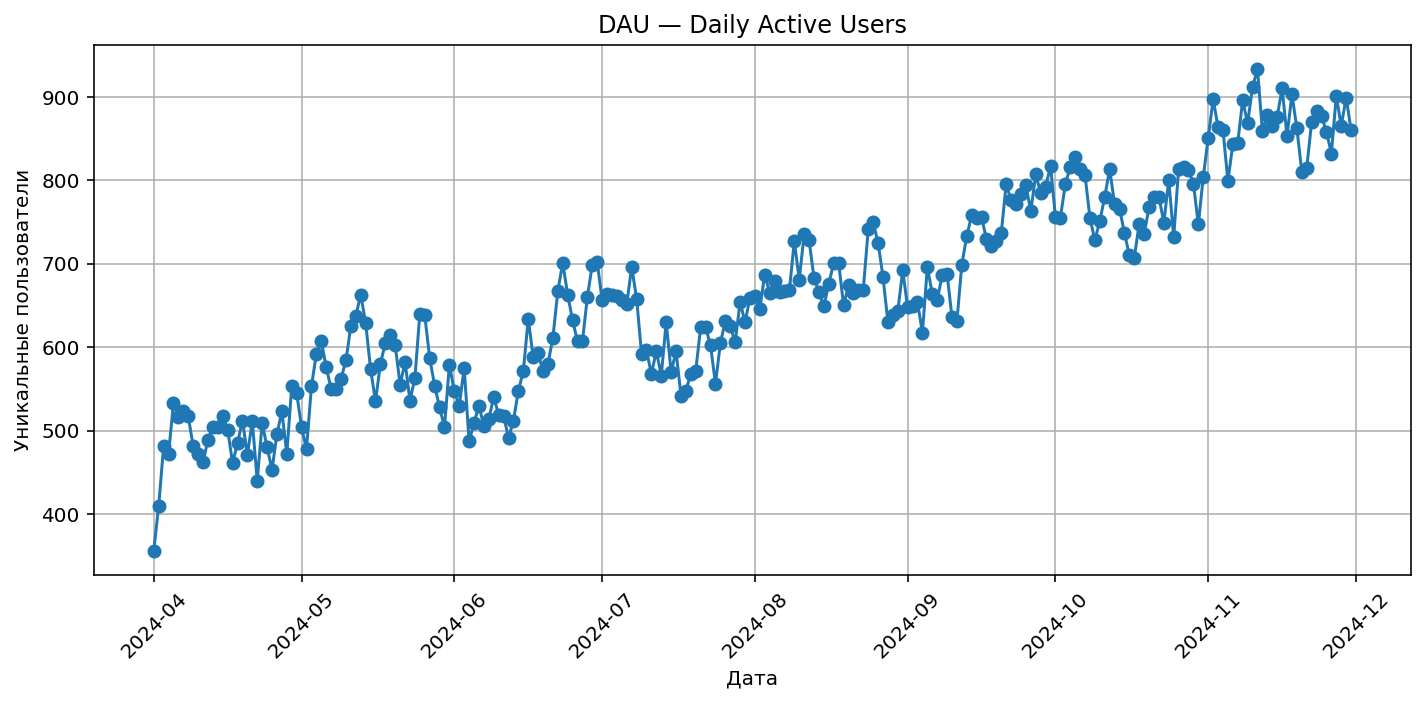

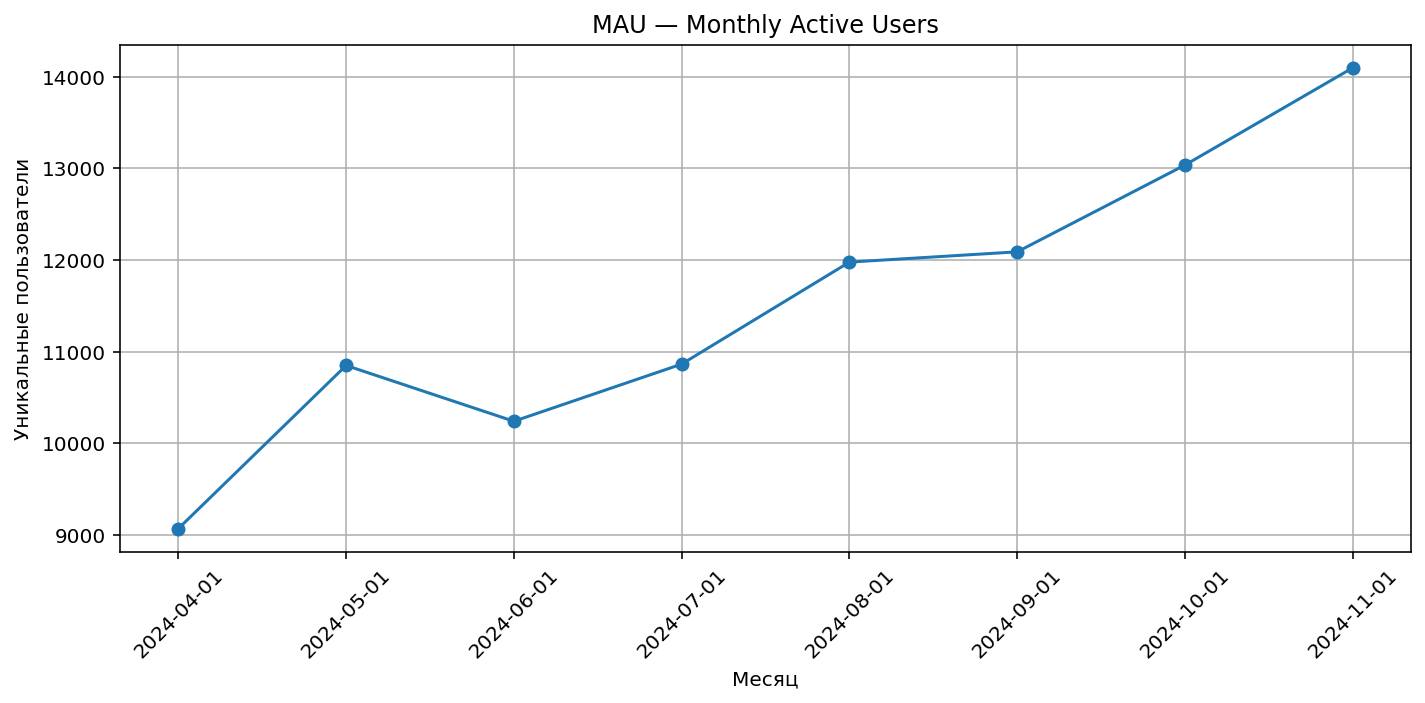

In [13]:
# Считаем DAU и MAU
visits['session_date'] = visits['session_start'].dt.normalize()
dau = visits.groupby('session_date')['user_id'].nunique().reset_index()
dau.rename(columns={'user_id':'dau'}, inplace=True)
visits['session_month'] = visits['session_start'].dt.to_period('M').dt.to_timestamp()
mau = visits.groupby('session_month')['user_id'].nunique().reset_index()
mau.rename(columns={'user_id':'mau'}, inplace=True)


# График DAU
plt.figure(figsize=(10, 5))
plt.plot(dau['session_date'], dau['dau'], marker='o')
plt.title('DAU — Daily Active Users')
plt.xlabel('Дата')
plt.ylabel('Уникальные пользователи')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# График MAU
plt.figure(figsize=(10, 5))
plt.plot(mau['session_month'].astype(str), mau['mau'], marker='o')
plt.title('MAU — Monthly Active Users')
plt.xlabel('Месяц')
plt.ylabel('Уникальные пользователи')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


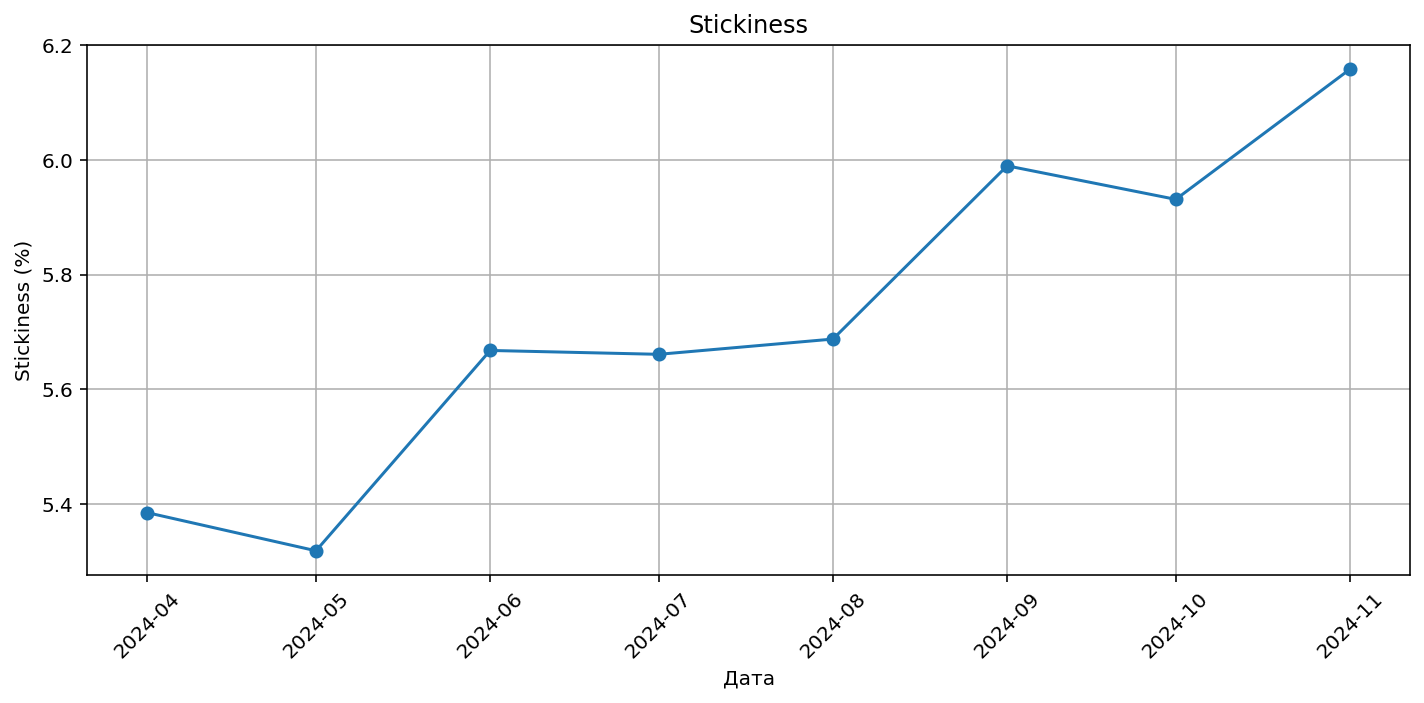

In [14]:
# Считаем stickiness
dau['session_date'] = pd.to_datetime(dau['session_date'])
dau['session_month'] = dau['session_date'].dt.to_period('M').dt.to_timestamp()
dau_monthly_average = dau.groupby(['session_month'])['dau'].mean().reset_index()
stickiness_table = pd.merge(mau, dau_monthly_average, on='session_month', how='left')
stickiness_table['stick'] = (stickiness_table['dau'] / stickiness_table['mau']) * 100

# Визуализируем stickiness
plt.figure(figsize=(10, 5))
plt.plot(stickiness_table['session_month'], stickiness_table['stick'], marker='o')
plt.title('Stickiness')
plt.xlabel('Дата')
plt.ylabel('Stickiness (%)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---
**Вывод по метрикам DAU, MAU, Stickiness**

С апреля 2024 по ноябрь 2024 года метрики имеют устойчивую тенденцию на рост. DAU, хоть и имеет большой шум, вырос с показателя 400 пользователей в день до 900. MAU - вырос с 9000 активных пользователей в месяц до 14000. Метрика Stickiness имеет небольшой спад с апреля по май и с сентября по октябрь, но в целом показывает рост примерно с 5,4% до 6,1%.

**Новый контент действительно повысил интерес и вовлеченность пользователей.**


---

In [15]:
profiles['first_month'].unique()

array(['2024-05-01T00:00:00.000000000', '2024-06-01T00:00:00.000000000',
       '2024-10-01T00:00:00.000000000', '2024-07-01T00:00:00.000000000',
       '2024-09-01T00:00:00.000000000', '2024-11-01T00:00:00.000000000',
       '2024-08-01T00:00:00.000000000', '2024-04-01T00:00:00.000000000'],
      dtype='datetime64[ns]')

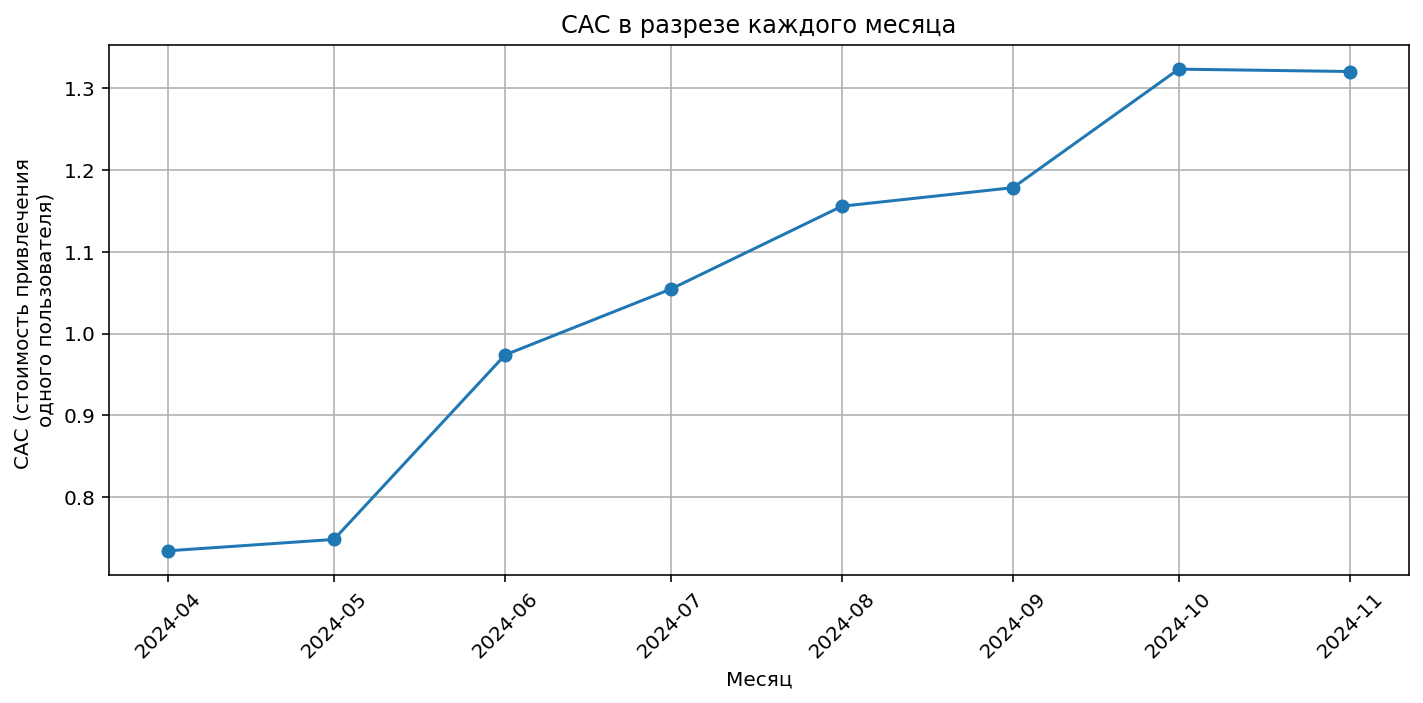

In [16]:
# Считаем метрики в разрезе каждого месяца привлечения новых пользователей

# CAC
profiles['first_month'] = profiles['first_dt'].dt.to_period('M').dt.to_timestamp()
monthly_cac = profiles.groupby('first_month')['cac'].mean().reset_index()
# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(monthly_cac['first_month'], monthly_cac['cac'], marker='o')
plt.title('CAC в разрезе каждого месяца')
plt.xlabel('Месяц')
plt.ylabel('САС (стоимость привлечения \nодного пользователя)')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


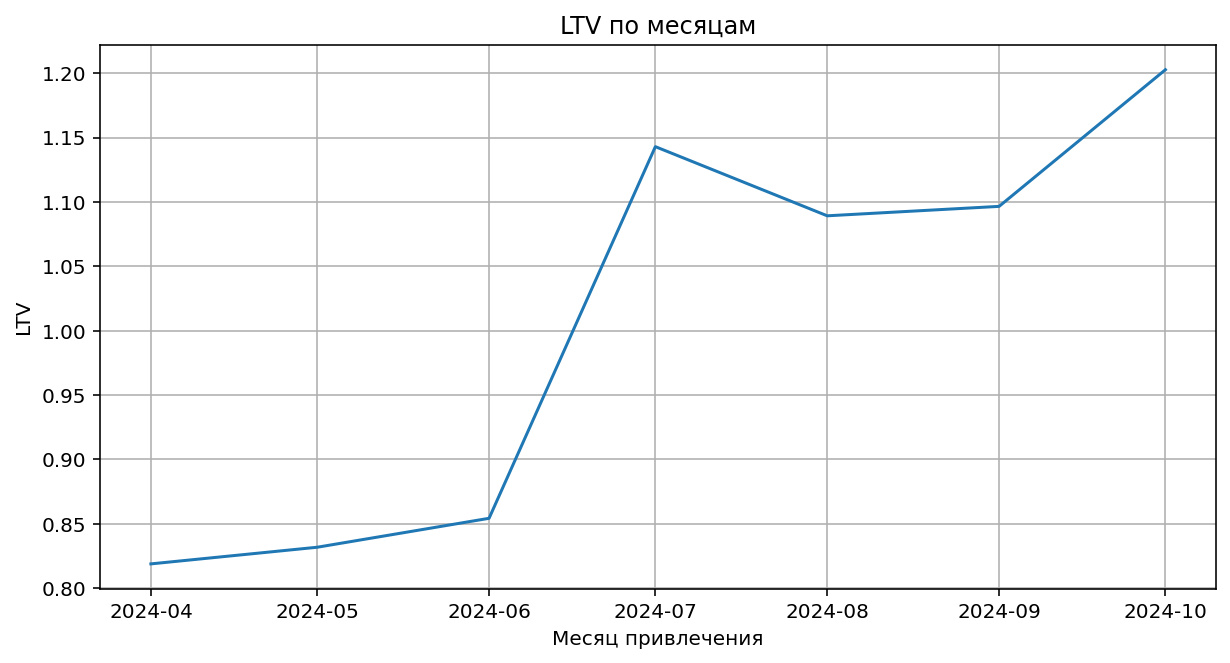

In [17]:
# Для расчета LTV и ROI создаем датасет с lifetime 28 дней
# Берем только пользователей со сроком жизни 28 дней или меньше
visits_28 = visits[(visits['lifetime'] <= 27)]
orders_28 = orders[(orders['lifetime'] <= 27)]
# Считаем LTV
orders_user_ltv = orders_28.groupby('user_id')['revenue'].sum().reset_index()
orders_user_ltv.rename(columns={'revenue': 'LTV'}, inplace=True)
# Объединяем со всеми пользователями
profiles_28 = profiles[profiles['user_id'].isin(visits_28['user_id'])]
profiles_ltv = pd.merge(profiles_28, orders_user_ltv, on='user_id', how='left')
profiles_ltv['LTV'] = profiles_ltv['LTV'].fillna(0)
# Месячный LTV (за вычетом последнего месяца, поскольку данные не полные)
profiles_ltv = profiles_ltv[profiles_ltv['first_month'] != '2024-11-01T00:00:00.000000000']
ltv_monthly = (profiles_ltv
 .groupby('first_month')
 .agg(total_revenue=('LTV','sum'),
      total_users=('user_id','nunique'))
 .assign(LTV=lambda x: x['total_revenue']/x['total_users'])
 .reset_index())

# Визуализация LTV
plt.figure(figsize=(10, 5))
plt.plot(ltv_monthly['first_month'], ltv_monthly['LTV'])
plt.title('LTV по месяцам')
plt.xlabel('Месяц привлечения')
plt.ylabel('LTV')
plt.grid(True)
plt.show()

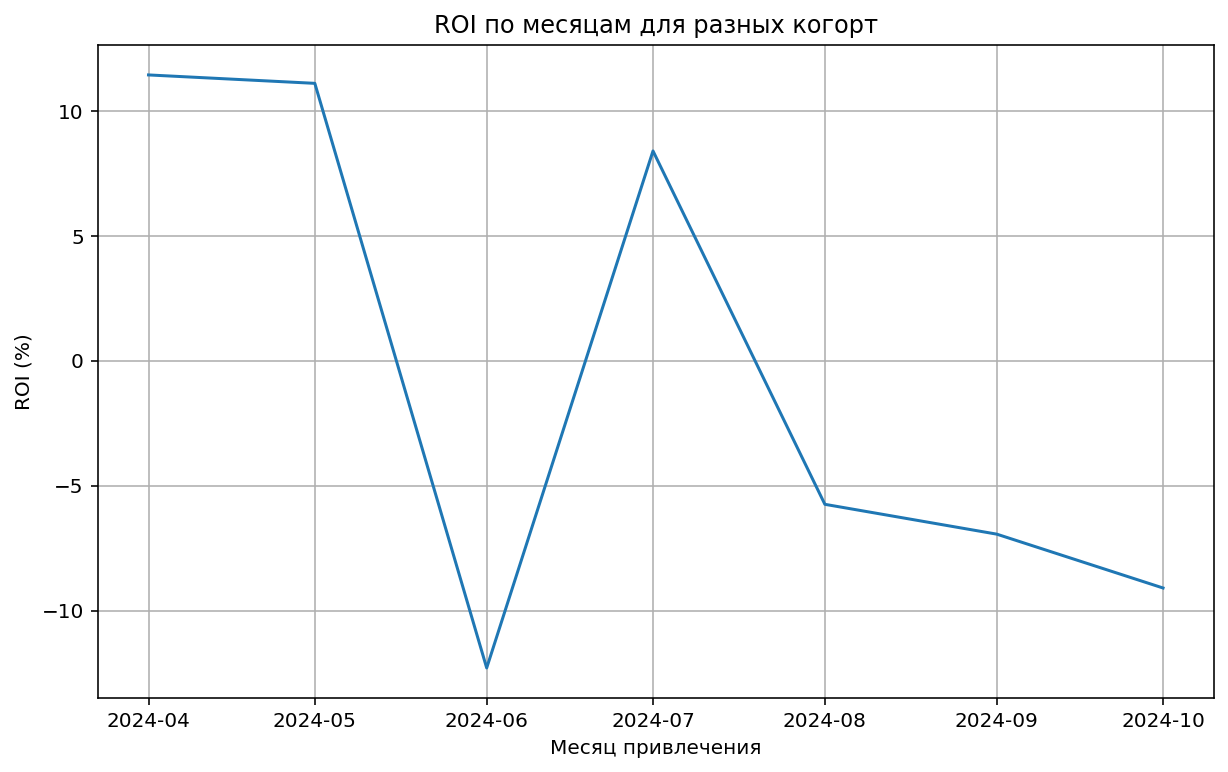

In [18]:
# ROI
# Объединяем датасеты, чтобы получить для каждого пользователя САС и LTV 
roi_monthly = pd.merge(ltv_monthly, monthly_cac, on='first_month', how='inner')
roi_monthly = roi_monthly[roi_monthly['first_month'] != '2024-11-01T00:00:00.000000000']
roi_monthly['ROI'] = (roi_monthly['LTV'] - roi_monthly['cac']) / roi_monthly['cac'] * 100

plt.figure(figsize=(10, 6))
plt.plot(roi_monthly['first_month'], roi_monthly['ROI'])
plt.title('ROI по месяцам для разных когорт')
plt.xlabel('Месяц привлечения')
plt.ylabel('ROI (%)')
plt.grid(True)
plt.show()

---
**Короткий вывод по метрикам САС, LTV и ROI.**


LTV за 28 дней резко растёт с июня — пользователи стали приносить больше выручки после запуска нового контента. После небольшого спада в июле рост продолжился.

CAC также резко растет, но с мая. С показателя меньше 0,8 он дорос до 1,3.

ROI сильно скачет на всем протяжении наблюдения. Он резко упал  в мае до показателя менее -10%, затем поднялся в июле до примерно 5.5%, снова упал до -5% в вагусте, а далее стал стагнировать. Очевидно, роста LTV не хватает, чтобы окупить CAC.

**Новый спортивный контент, запущенный в начале лета, дал положительный эффект на вовлечённость и монетизацию, но стоимость привлечения не окупается.**

---

## Анализ метрик в разрезе источника привлечения

Теперь необходимо разобраться, какие источники привлечения перспективны, а какие за 28 дней не окупились.

**Задача 1**. Определите самые популярные источники привлечения:
- Посчитайте общее число привлечённых пользователей для каждого источника.
- Визуализируйте динамику набора новых пользователей по дням в каждом источнике.
- Рассчитайте и визуализируйте динамику DAU, MAU и Stickiness по источникам привлечения.

**Задача 2**. Изучите динамику изменения метрик на 28-й день в разрезе источника. Проведите анализ с выделением недельных когорт по дате привлечения. Рассчитайте и визуализируйте:
- Скользящее удержание на 14-й день с момента привлечения (за период с 14-го по 28-й день).
- Конверсию в покупку.

Недельную динамику затрат на маркетинг по каждому источнику привлечения.
Динамику среднего CAC, значений LTV и ROI.

По результатам проведите анализ рекламных каналов. Дайте общую характеристику каждому рекламному каналу по рассчитанным метрикам. Укажите, какие рекламные каналы не вышли на уровень окупаемости за ожидаемый период, и предположите почему.


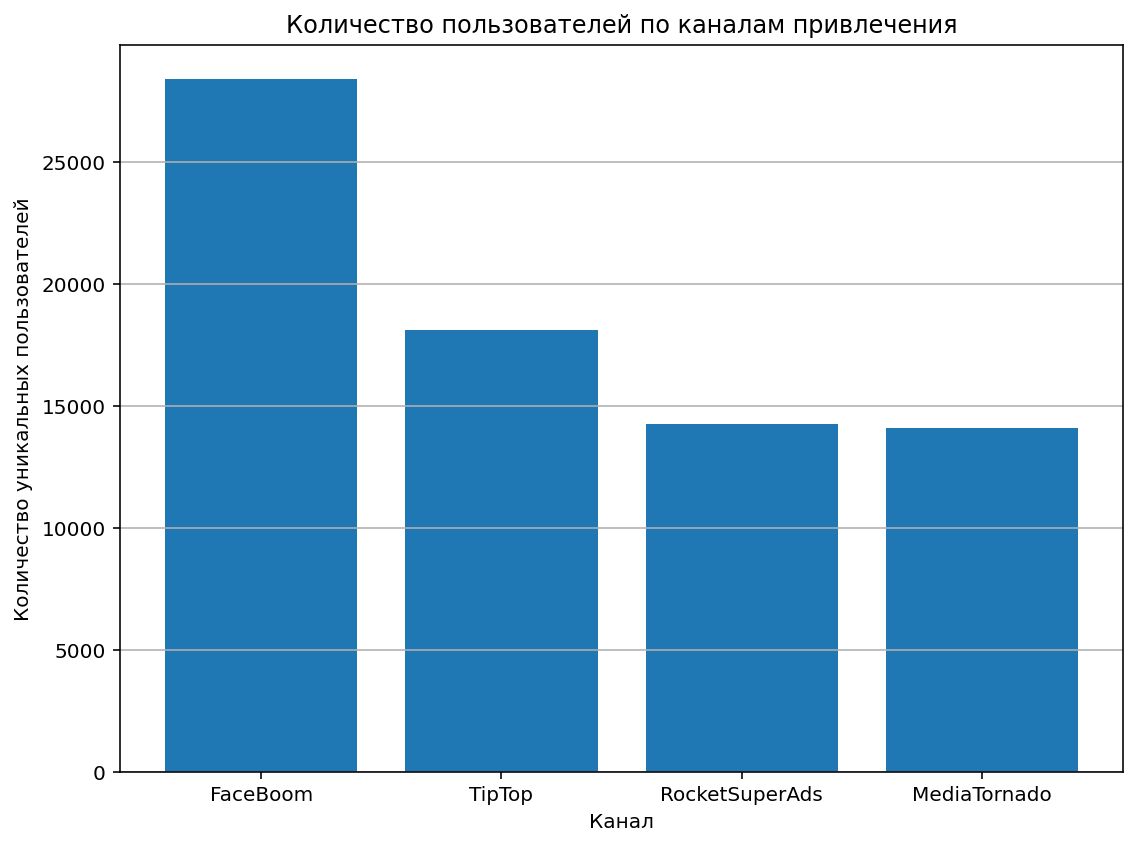

In [19]:
# Задача 1. Анализ источников привлечения.
# Число привлеченных пользователей
count_channel = visits.groupby('first_channel')['user_id'].nunique().reset_index()
count_channel = count_channel.sort_values(by='user_id', ascending=False)

# Визуализация
plt.figure(figsize=(8, 6))
plt.bar(count_channel['first_channel'], count_channel['user_id'])
plt.title('Количество пользователей по каналам привлечения')
plt.xlabel('Канал')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

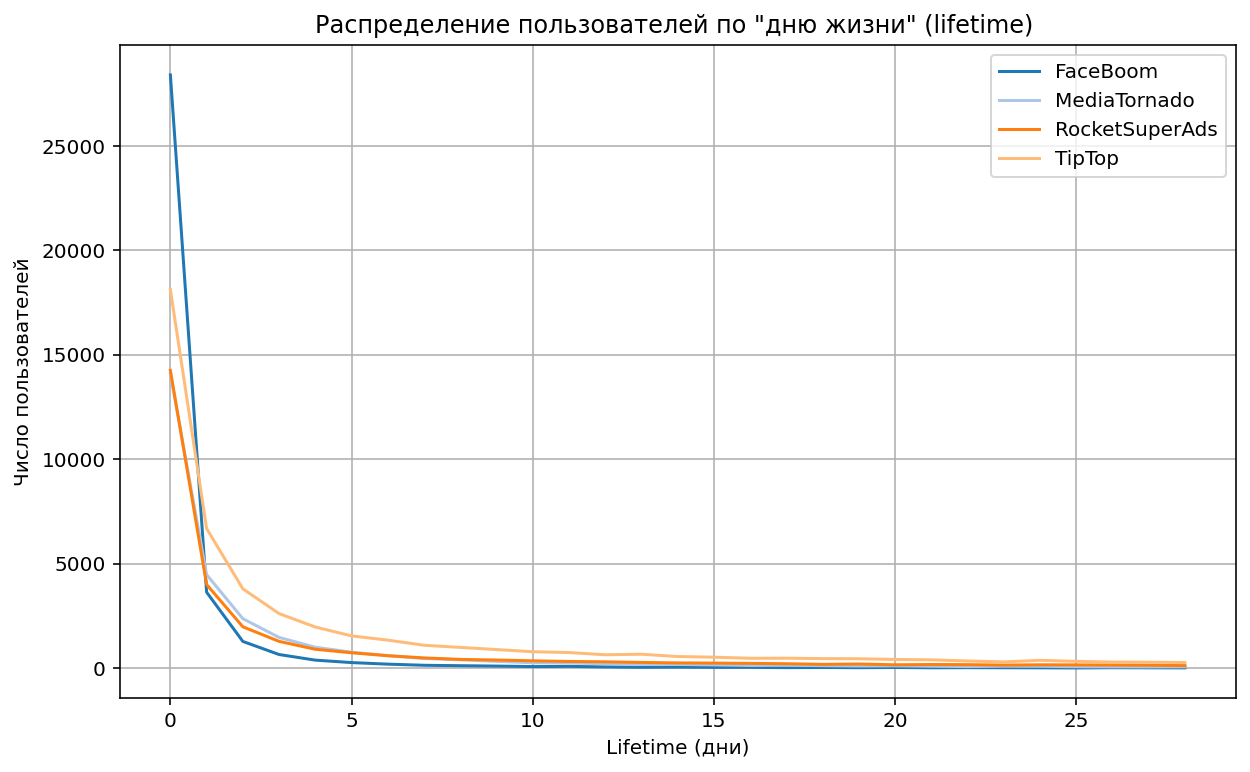

In [20]:
# Распределение пользователей по "дню жизни" (lifetime) 
dynamic = visits.groupby(['first_channel', 'lifetime'])['user_id'].nunique().reset_index()
dynamic.rename(columns={'user_id':'count_users'}, inplace=True)
channels = dynamic['first_channel'].unique().tolist()
# Визуализация и дополнительно ограничим лайфтайм
plt.figure(figsize=(10, 6))
for channel in channels:
    df_plot = dynamic[(dynamic['first_channel'] == channel) & (dynamic['lifetime'] <= 28)]
    plt.plot(df_plot['lifetime'], df_plot['count_users'], label=channel)

plt.title('Распределение пользователей по "дню жизни" (lifetime) ')
plt.xlabel('Lifetime (дни)')
plt.ylabel('Число пользователей')
plt.legend()
plt.grid(True)
plt.show()

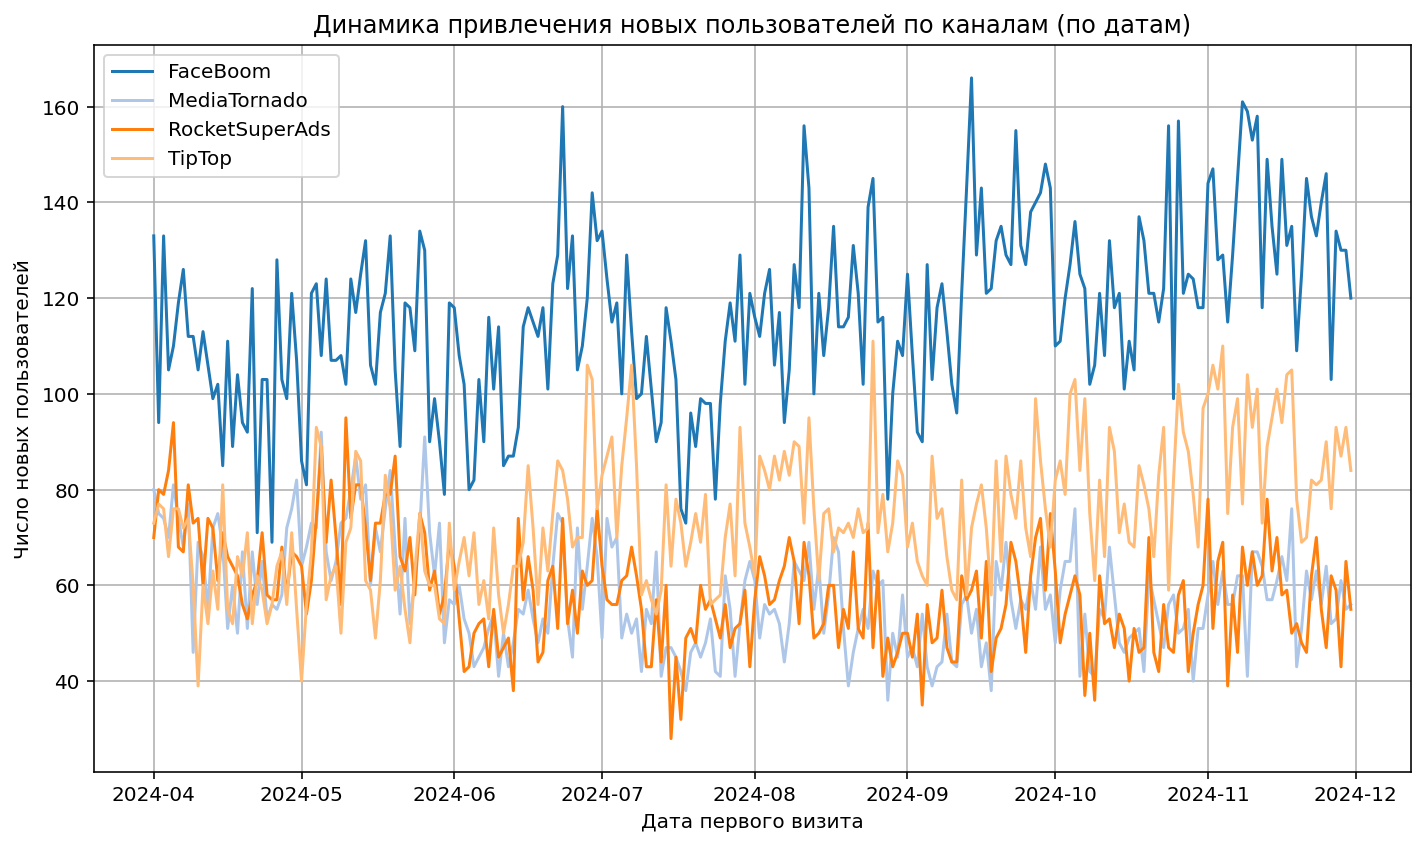

In [21]:
# Динамика набора новых пользователей
new_users_daily = visits.groupby(['first_dt', 'first_channel'])['user_id'].nunique().reset_index()
new_users_daily.rename(columns={'user_id': 'new_users'}, inplace=True)
# Визуализация
plt.figure(figsize=(10, 6))
for channel in new_users_daily['first_channel'].unique():
    df_plot = new_users_daily[new_users_daily['first_channel'] == channel]
    plt.plot(df_plot['first_dt'], df_plot['new_users'], label=channel)

plt.title('Динамика привлечения новых пользователей по каналам (по датам)')
plt.xlabel('Дата первого визита')
plt.ylabel('Число новых пользователей')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

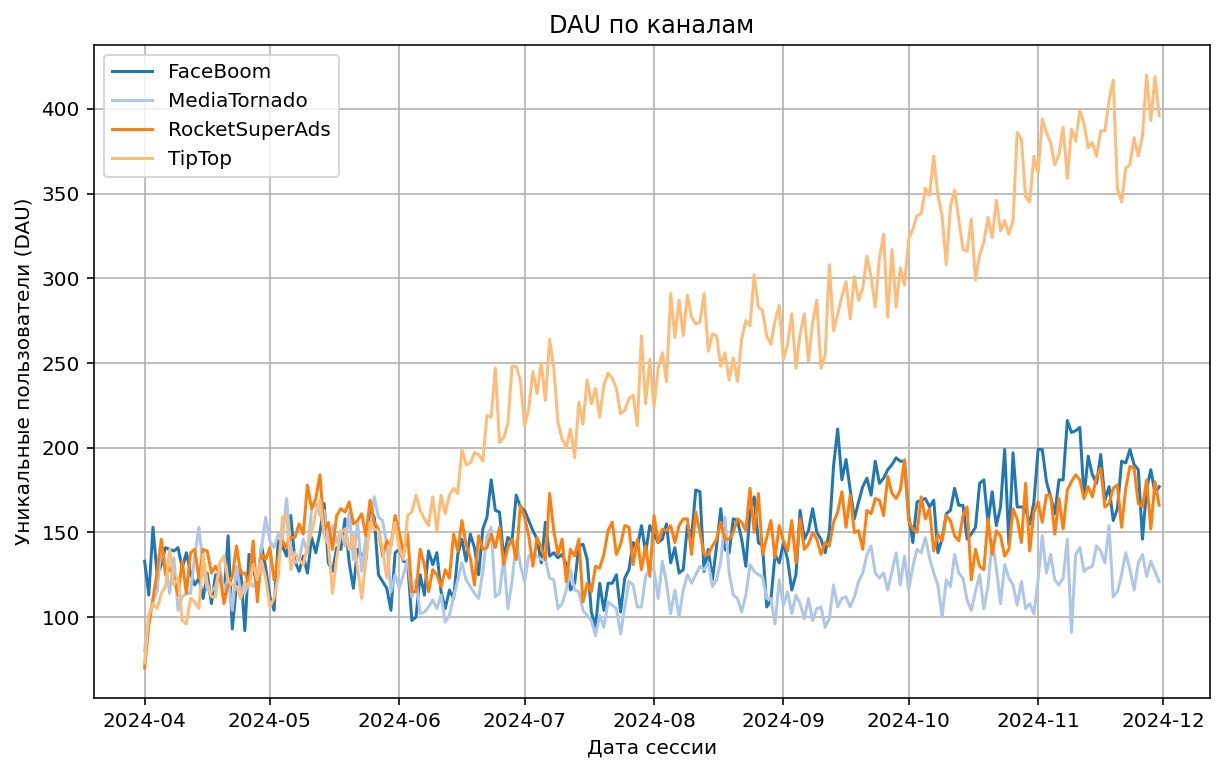

In [22]:
# DAU
dau = visits.groupby(['session_date', 'first_channel'])['user_id'].nunique().reset_index()
dau.rename(columns={'user_id':'dau'}, inplace=True)
# Визуализация
plt.figure(figsize=(10, 6))
for channel in channels:
    df_plot = dau[(dau['first_channel'] == channel)]
    plt.plot(df_plot['session_date'], df_plot['dau'], label=channel)

plt.title('DAU по каналам')
plt.xlabel('Дата сессии')
plt.ylabel('Уникальные пользователи (DAU)')
plt.legend()
plt.grid(True)
plt.show()

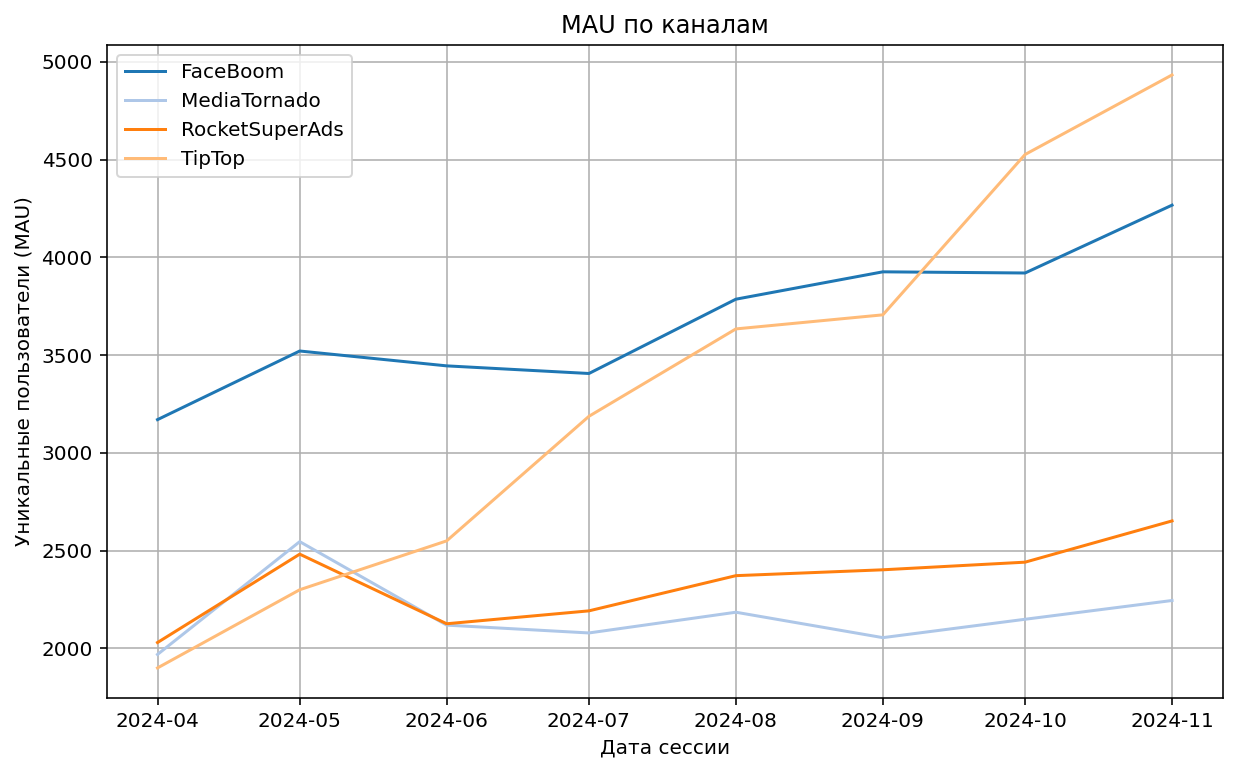

In [23]:
# MAU
mau = visits.groupby(['session_month', 'first_channel'])['user_id'].nunique().reset_index()
mau.rename(columns={'user_id':'mau'}, inplace=True)
# Визуализация
plt.figure(figsize=(10, 6))
for channel in channels:
    df_plot = mau[(mau['first_channel'] == channel)]
    plt.plot(df_plot['session_month'], df_plot['mau'], label=channel)

plt.title('MAU по каналам')
plt.xlabel('Дата сессии')
plt.ylabel('Уникальные пользователи (MAU)')
plt.legend()
plt.grid(True)
plt.show()

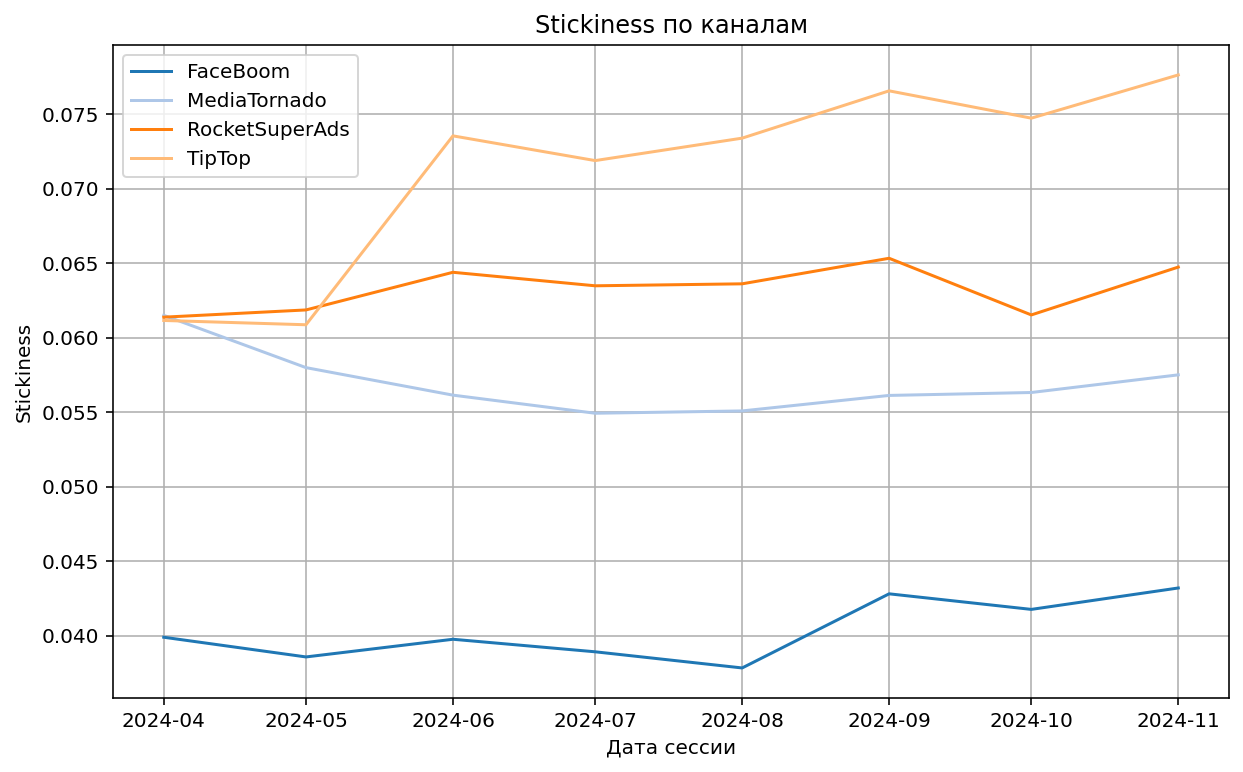

In [24]:
# Stickiness 
dau['session_month'] = dau['session_date'].dt.to_period('M').dt.to_timestamp()
dau_monthly = dau.groupby(['session_month', 'first_channel'])['dau'].mean().reset_index()
stickiness = pd.merge(mau, dau_monthly, on=['session_month', 'first_channel'], how='left')
stickiness['stick'] = stickiness['dau'] / stickiness['mau']

# Визуализация
plt.figure(figsize=(10, 6))
for channel in channels:
    df_plot = stickiness[(stickiness['first_channel'] == channel)]
    plt.plot(df_plot['session_month'], df_plot['stick'], label=channel)

plt.title('Stickiness по каналам')
plt.xlabel('Дата сессии')
plt.ylabel('Stickiness')
plt.legend()
plt.grid(True)
plt.show()

---

**Вывод по пользовательским метрикам в разрезе каналов привлечения.**

**TipTop** — лидер по росту и вовлечению

**RocketSuperAds** — стабильный и эффективный

**FaceBoom** — надёжный по объёму, но требует улучшения удержания

**MediaTornado** — привлекает мало пользователей, но имеет среднее удержание

---



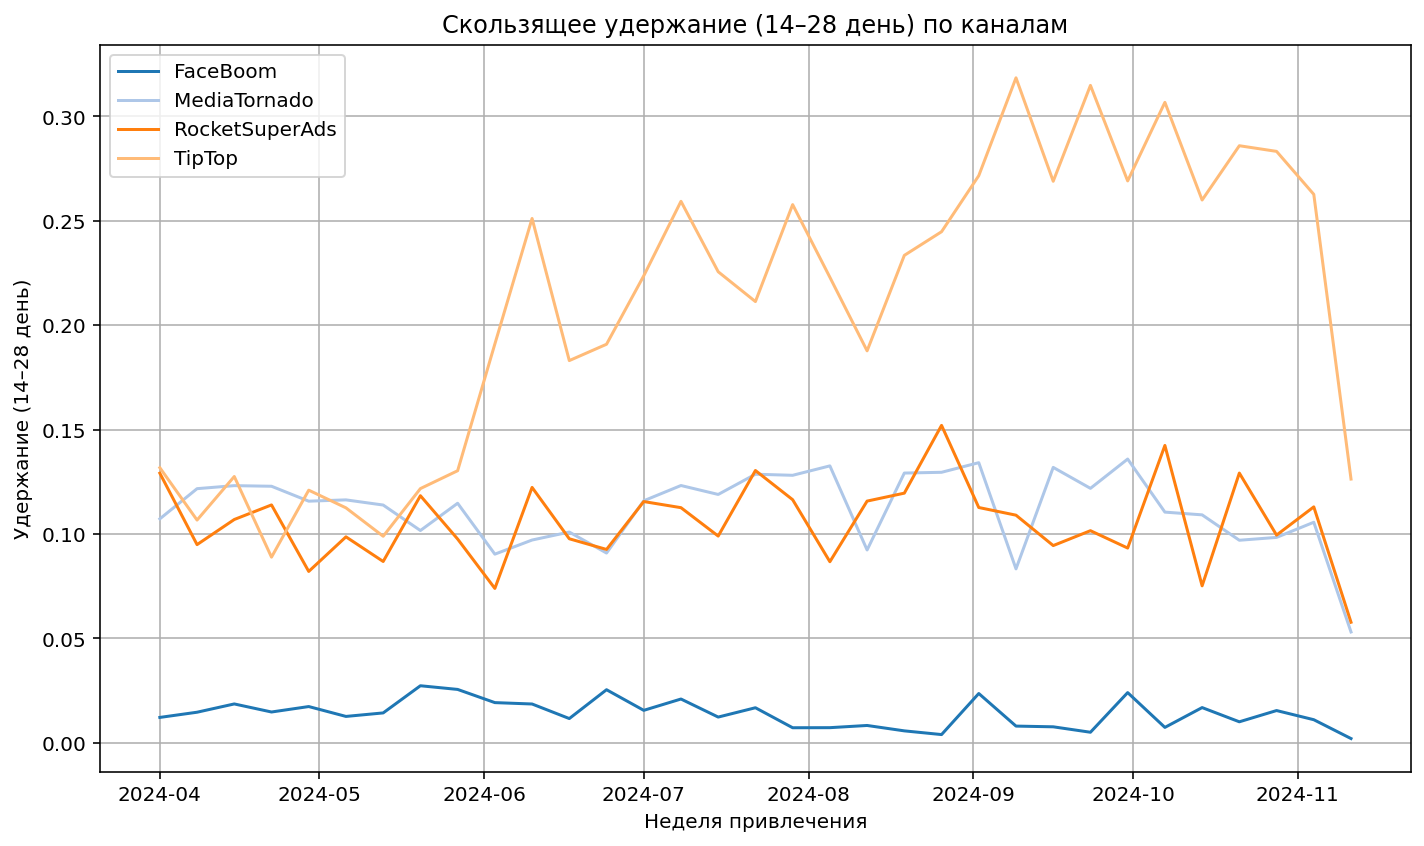

In [25]:
# Задача 2
# Строим недельные когорты
visits['cohort_week'] = visits['first_dt'] - pd.to_timedelta(visits['first_dt'].dt.weekday, unit='d')
profiles['cohort_week'] = profiles['first_dt'] - pd.to_timedelta(profiles['first_dt'].dt.weekday, unit='d')
orders['cohort_week'] = orders['first_dt'] - pd.to_timedelta(orders['first_dt'].dt.weekday, unit='d')

# Скользящее удержание (визиты с 14 по 28 день lifetime)
retained = visits[((visits['lifetime'] >= 13) & (visits['lifetime'] <= 27))]
retained_users = retained.groupby(['cohort_week', 'first_channel'])['user_id'].nunique().reset_index(name='retained')
# Базовая когорта (на 0-й день)
cohort_sizes = visits[visits['lifetime'] == 0].groupby(['cohort_week', 'first_channel'])['user_id'].nunique().reset_index(name='cohort_size')
# Объединяем
retention = pd.merge(cohort_sizes, retained_users, on=['cohort_week', 'first_channel'], how='left')
retention['retention_14_28'] = retention['retained'] / retention['cohort_size']

# Визуализация
plt.figure(figsize=(10, 6))
for channel in channels:
    df_plot = retention[retention['first_channel'] == channel]
    plt.plot(df_plot['cohort_week'], df_plot['retention_14_28'], label=channel)
plt.title('Скользящее удержание (14–28 день) по каналам')
plt.xlabel('Неделя привлечения')
plt.ylabel('Удержание (14–28 день)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


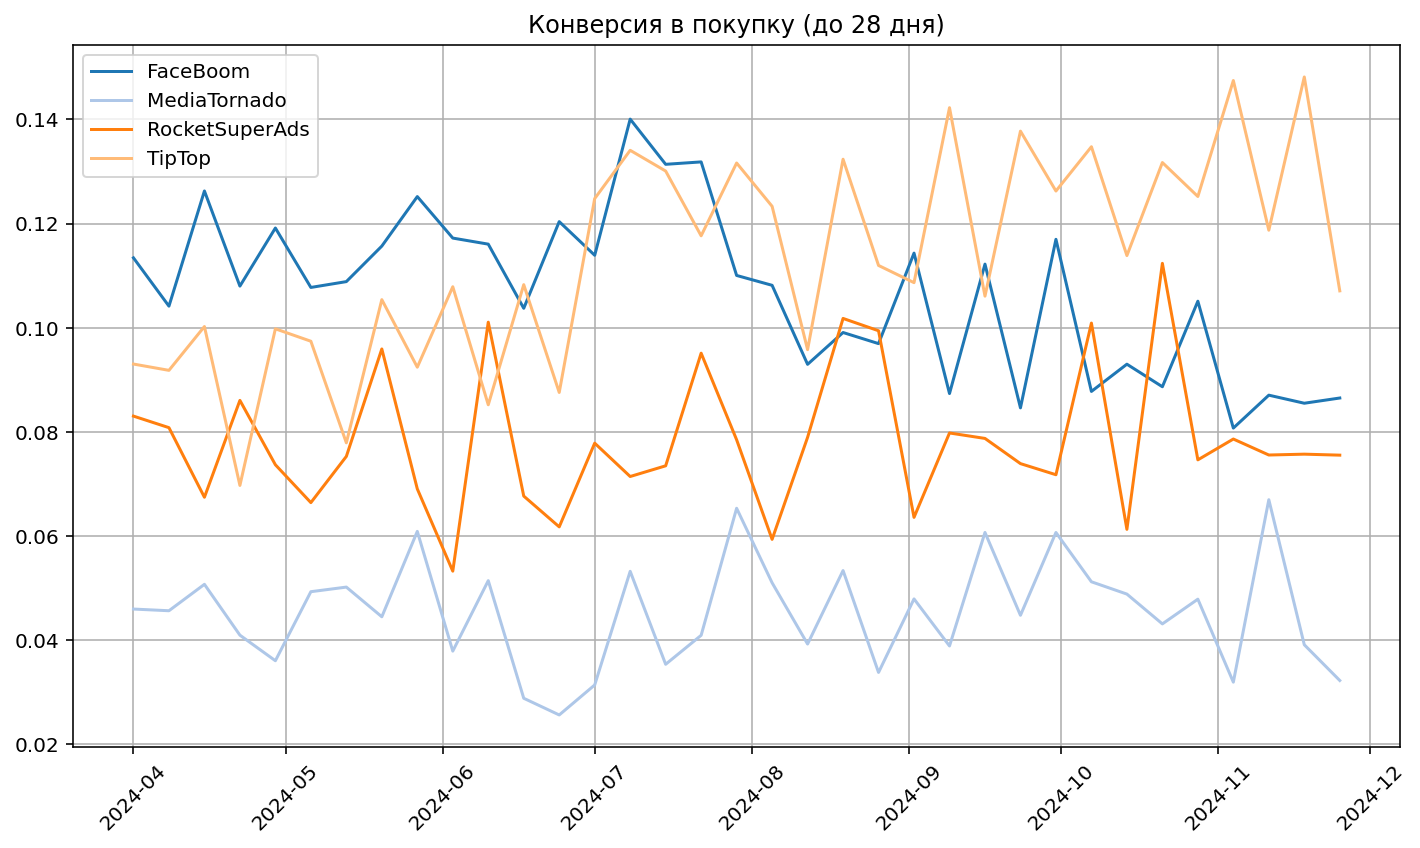

In [26]:
# Конверсия в покупку
orders_28 = orders[orders['lifetime'] <= 28]
converted = orders_28.groupby(['user_id', 'first_channel', 'first_dt']).size().reset_index()
conversion = converted.groupby(['first_channel', 'first_dt'])['user_id'].nunique().reset_index(name='buyers')
conversion['cohort_week'] = conversion['first_dt'] - pd.to_timedelta(conversion['first_dt'].dt.weekday, unit='d')
users_in_cohort = visits.groupby(['cohort_week', 'first_channel'])['user_id'].nunique().reset_index(name='users')
# Объединяем
conversion = pd.merge(users_in_cohort, 
                      conversion.groupby(['cohort_week', 'first_channel'])['buyers'].sum().reset_index(),
                      on=['cohort_week', 'first_channel'],
                      how='left')
conversion['conversion_rate'] = conversion['buyers'] / conversion['users']

# Визуализация
plt.figure(figsize=(10, 6))
for channel in conversion['first_channel'].unique():
    df_plot = conversion[conversion['first_channel'] == channel]
    plt.plot(df_plot['cohort_week'], df_plot['conversion_rate'], label=channel)
plt.title("Конверсия в покупку (до 28 дня)")
plt.legend(); plt.xticks(rotation=45); plt.grid(); plt.tight_layout()
plt.show()

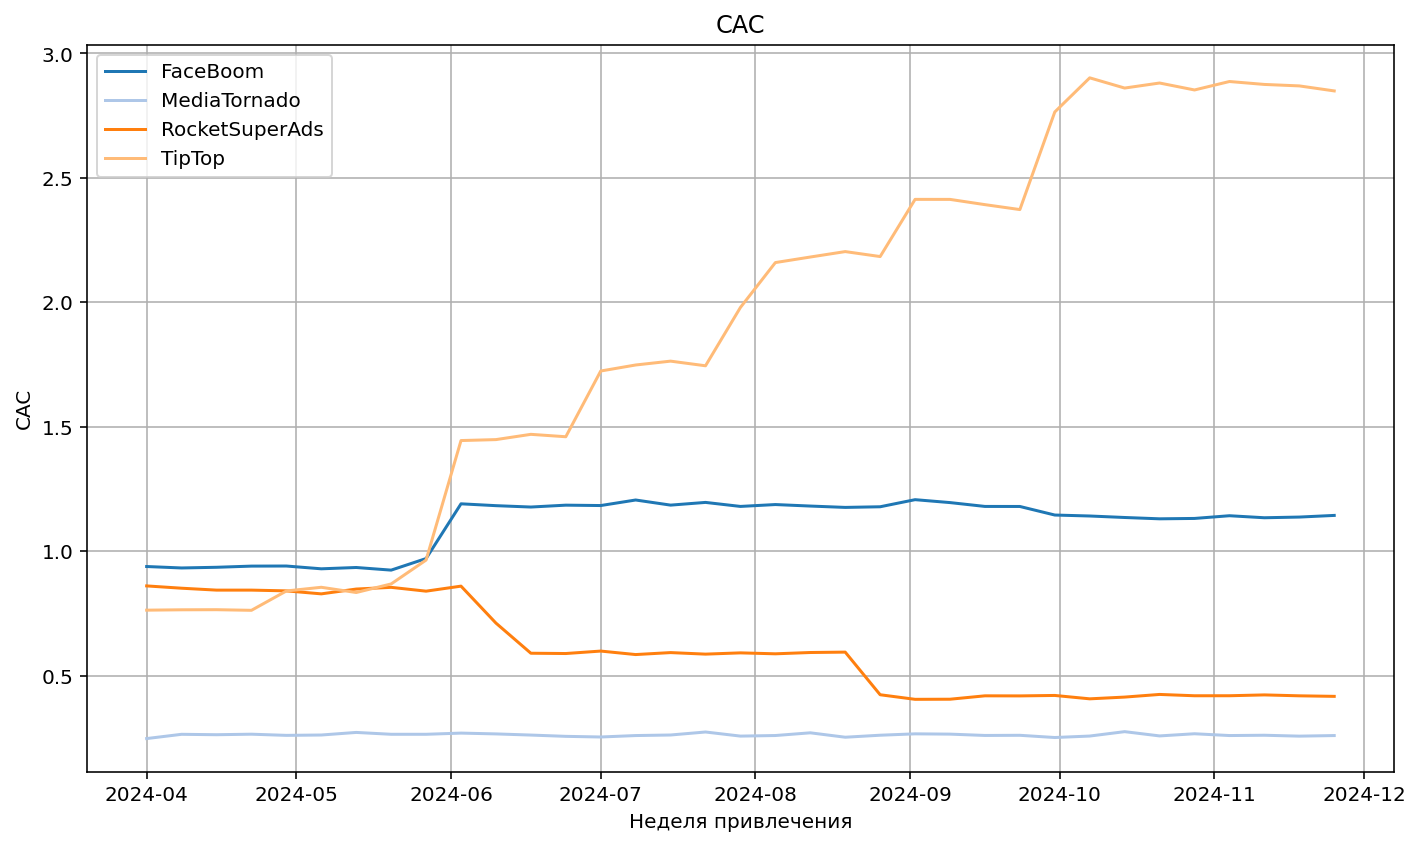

In [27]:
# САС
profiles['cohort_week'] = profiles['first_dt'] - pd.to_timedelta(profiles['first_dt'].dt.weekday, unit='d')
cac = pd.merge(users_in_cohort, profiles, on=['cohort_week', 'first_channel'])
cac_week = cac.groupby(['cohort_week', 'first_channel'])['cac'].mean().reset_index()

# Визуализация
plt.figure(figsize=(10, 6))
for channel in channels:
    df_plot = cac_week[cac_week['first_channel'] == channel]
    plt.plot(df_plot['cohort_week'], df_plot['cac'], label=channel)

plt.title('CAC')
plt.xlabel('Неделя привлечения')
plt.ylabel('CAC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

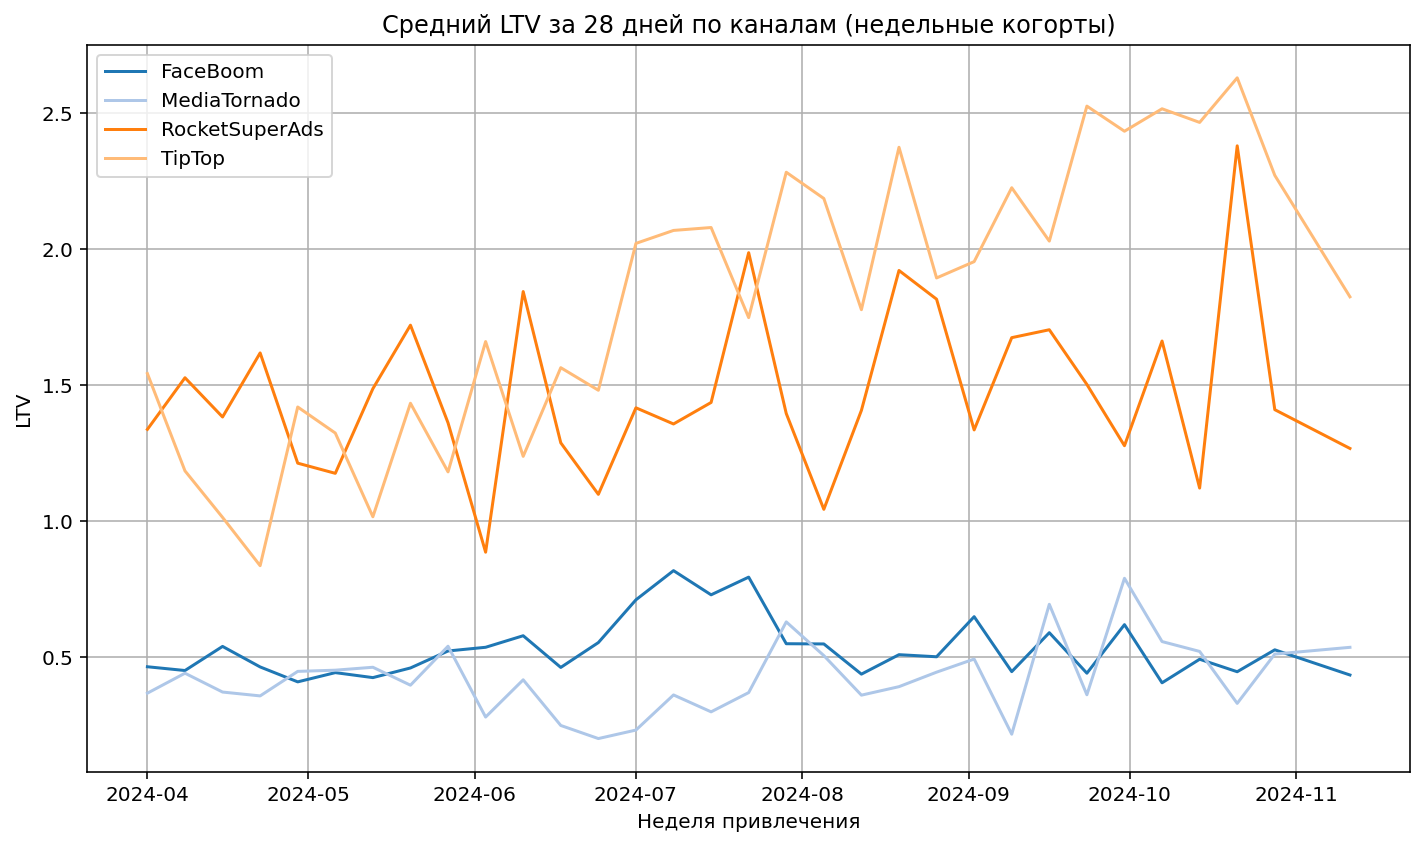

In [28]:
# LTV
# Объединяем заказы с профилем, чтобы получить дату привлечения
orders_28 = pd.merge(
    orders[['user_id', 'event_dt', 'revenue']],
    profiles[['user_id', 'first_dt', 'first_channel', 'cohort_week', 'cac']],
    on='user_id',
    how='left'
)
# Расчет lifetime и фильтрация по 28 дням
orders_28['lifetime'] = (orders_28['event_dt'].dt.normalize() - orders_28['first_dt']).dt.days
orders_28 = orders_28[orders_28['lifetime'] <= 27]
# Суммируем выручку за 28 дней по пользователям
ltv_by_user = orders_28.groupby('user_id')['revenue'].sum().reset_index(name='LTV')
# Добавляем всех пользователей
ltv_raw = pd.merge(
    profiles[['user_id', 'first_channel', 'cohort_week']],
    ltv_by_user,
    on='user_id',
    how='left'
)
ltv_raw['LTV'] = ltv_raw['LTV'].fillna(0)
# Исключаем последний месяц
excluded_cohort = [
    '2024-11-18T00:00:00.000000000',
    '2024-11-25T00:00:00.000000000',
    '2024-11-04T00:00:00.000000000'
]
ltv_raw = ltv_raw[~ltv_raw['cohort_week'].isin(excluded_cohort)]

# Средний LTV по когорте и каналу
ltv_grouped = ltv_raw.groupby(['cohort_week', 'first_channel'])['LTV'].mean().reset_index()

# Визуализация
plt.figure(figsize=(10, 6))
for channel in ltv_grouped['first_channel'].unique():
    df_plot = ltv_grouped[ltv_grouped['first_channel'] == channel]
    plt.plot(df_plot['cohort_week'], df_plot['LTV'], label=channel)

plt.title('Средний LTV за 28 дней по каналам (недельные когорты)')
plt.xlabel('Неделя привлечения')
plt.ylabel('LTV')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


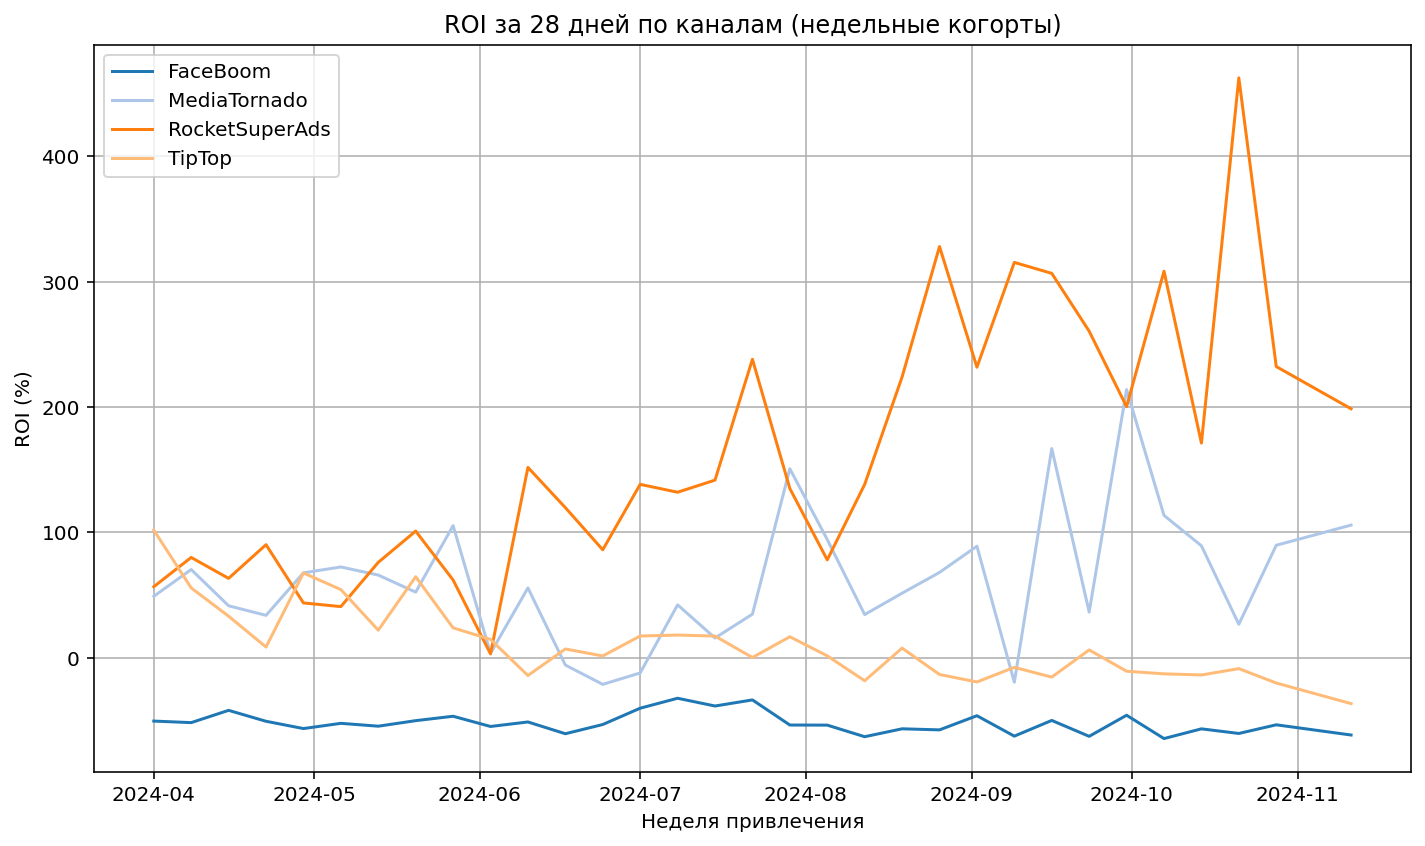

In [29]:
# ROI
# Объединяем профили с LTV (включая 0) и CAC
roi_df = pd.merge(
    profiles[['user_id', 'first_channel', 'cohort_week', 'cac']],
    ltv_raw[['user_id', 'LTV']],
    on='user_id',
    how='left'
)
# Исключаем последний месяц
excluded_cohort = [
    '2024-11-18T00:00:00.000000000',
    '2024-11-25T00:00:00.000000000',
    '2024-11-04T00:00:00.000000000'
]
roi_df = roi_df[~roi_df['cohort_week'].isin(excluded_cohort)]

roi_df['LTV'] = roi_df['LTV'].fillna(0)
roi_df['ROI'] = (roi_df['LTV'] - roi_df['cac']) / roi_df['cac'] * 100
ROI_grouped = roi_df.groupby(['cohort_week', 'first_channel'])['ROI'].mean().reset_index()

# Визуализация ROI по каналам
plt.figure(figsize=(10, 6))
for channel in ROI_grouped['first_channel'].unique():
    df_plot = ROI_grouped[ROI_grouped['first_channel'] == channel]
    plt.plot(df_plot['cohort_week'], df_plot['ROI'], label=channel)

plt.title('ROI за 28 дней по каналам (недельные когорты)')
plt.xlabel('Неделя привлечения')
plt.ylabel('ROI (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

---

**Анализ рекламных каналов.**


- **RocketSuperAds** — по ROI выраженный рост, в пиках > 300%, стабильный положительный тренд. LTV выский и растет. САС умеренный и стабилен с небольшим падением. Удержание стабильное, но не очень большое. Конверсия средняя.
-  **TipTop** — ROI стабильно падает. LTV сильно растет, однако САС тоже растет. Удержание высокое. Конверсия высокая и растет.
-   **FaceBoom** — ROI стабильно отрицательный (-20% ... -50%) из-за низкого LTV и достаточно высокого САС. Удержание очень низкие, конверсия же достаточно высокая. 
-    **MediaTornado** — ROI сдержанный (0-70%) и плавно колеблется. LTV низкий, но стабильный. При этом САС самый низкий. Удержание ниже среднего и низкая конверсия. 

## Анализ периода окупаемости маркетинговых вложений

Для источников, которые к 28-му дню не выходят на уровень окупаемости, рассчитайте и визуализируйте в виде тепловой карты значения ROI за больший период, например за 8–10 недель.

Разделите данные на недельные когорты по дате привлечения, в качестве интервала наблюдений используйте недели.

Сделайте вывод о том, за какой период окупаются вложения в эти источники.

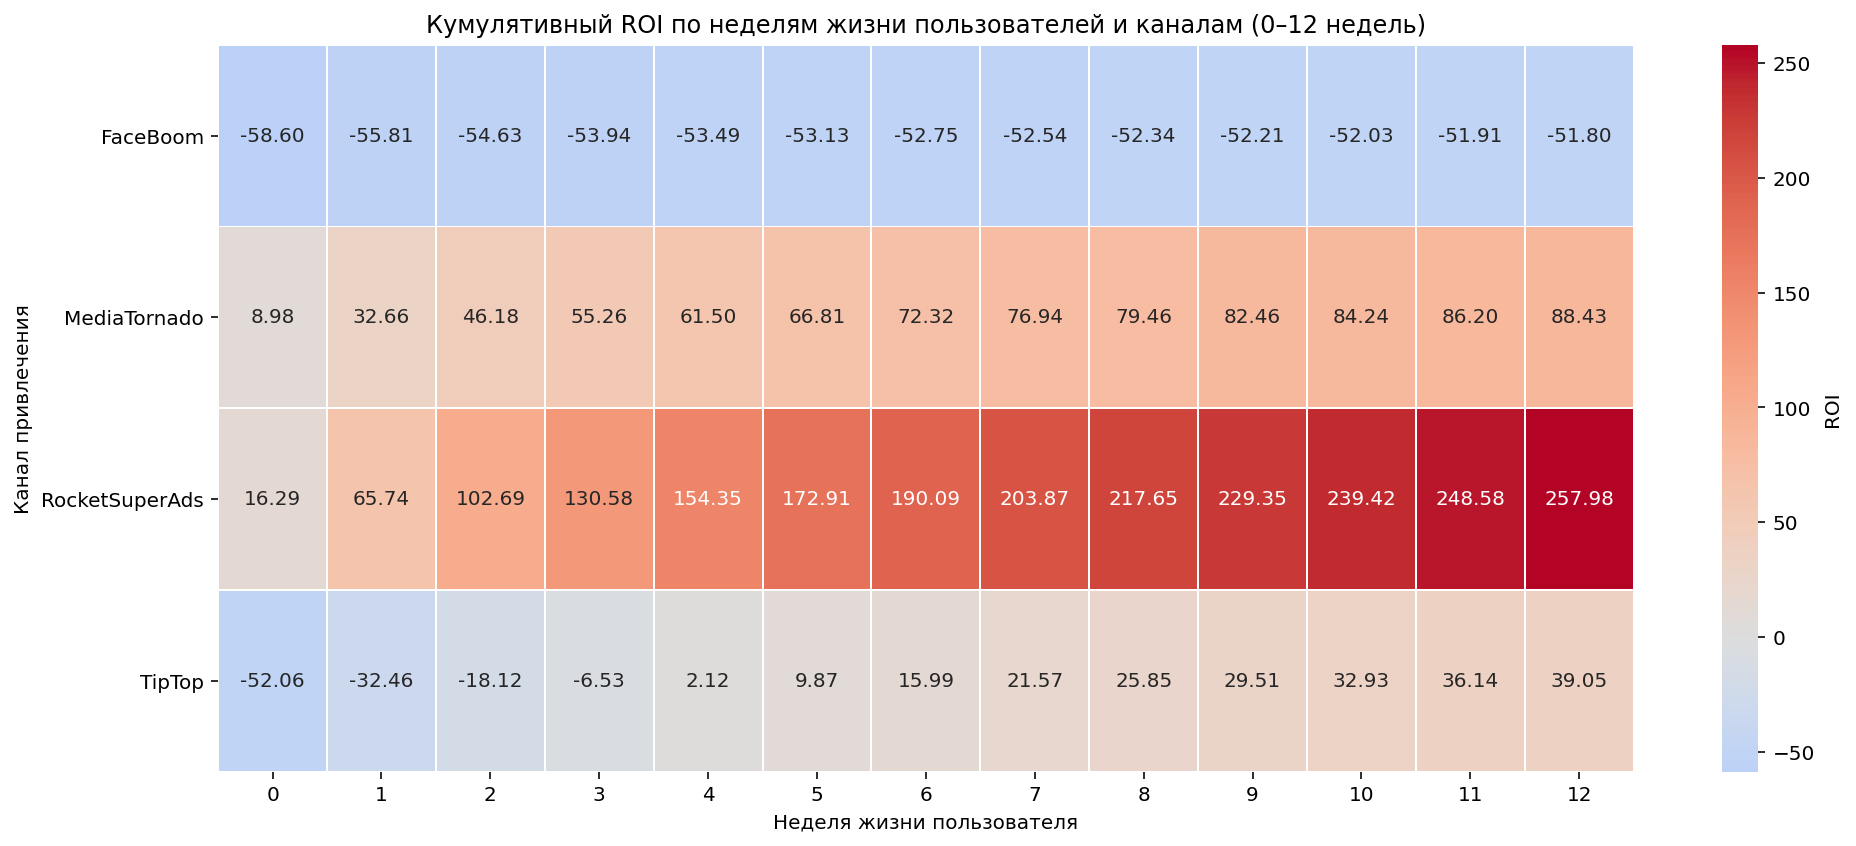

In [30]:
MAX_WEEK = 12

# Подготовка: вычисляем неделю жизни и кумулятивный LTV внутри orders
orders['week_lifetime'] = (orders['lifetime'] // 7).astype(int)
# Считаем еженедельную выручку
orders_weekly = (
    orders
    .groupby(['user_id','week_lifetime'], as_index=False)['revenue']
    .sum()
)
# Кумулятив
orders_weekly = orders_weekly.sort_values(['user_id','week_lifetime'])
orders_weekly['cum_revenue'] = orders_weekly.groupby('user_id')['revenue'].cumsum()
# Список всех пользователей
all_users = pd.Index(
    pd.concat([orders['user_id'], visits['user_id']]).unique(),
    name='user_id'
)
all_weeks = pd.Index(np.arange(0, MAX_WEEK + 1), name='week_lifetime')
full_index = pd.MultiIndex.from_product([all_users, all_weeks])
full = pd.DataFrame(index=full_index).reset_index()
# Вставляем кумулятивную выручку, заполняем пропуски
full = pd.merge(
    full,
    orders_weekly[['user_id', 'week_lifetime', 'cum_revenue']],
    on=['user_id', 'week_lifetime'],
    how='left'
)
full = full.sort_values(['user_id', 'week_lifetime'])
full['cum_revenue'] = full.groupby('user_id')['cum_revenue'].ffill().fillna(0)
# Подтягиваем канал и CAC
visits_unique = visits[['user_id', 'first_channel', 'cohort_week']].drop_duplicates('user_id')
full = pd.merge(full, visits_unique, on='user_id', how='left')
full = pd.merge(full, profiles[['user_id', 'cac']], on='user_id', how='left')
# Считаем суммарный CAC по каждому каналу
cac_by_channel = (
    full[full['week_lifetime'] == 0]
    .groupby('first_channel', as_index=False)['cac']
    .sum()
    .rename(columns={'cac': 'total_cac'})
)
# Суммарная кумулятивная выручка по каналу и неделе
rev_by_channel = (
    full.groupby(['first_channel', 'week_lifetime'], as_index=False)['cum_revenue']
    .sum()
    .rename(columns={'cum_revenue': 'total_revenue'})
)
# ROI
roi_by_channel = pd.merge(rev_by_channel, cac_by_channel, on='first_channel')
roi_by_channel['ROI'] = (
    roi_by_channel['total_revenue'] - roi_by_channel['total_cac']
) / roi_by_channel['total_cac'] * 100
# Pivot
roi_pivot = roi_by_channel.pivot(
    index='first_channel',
    columns='week_lifetime',
    values='ROI'
)
plt.figure(figsize=(14, 6))
sns.heatmap(
    roi_pivot,
    annot=True,
    fmt='.2f',
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label': 'ROI'}
)
plt.title(f'Кумулятивный ROI по неделям жизни пользователей и каналам (0–{MAX_WEEK} недель)')
plt.xlabel('Неделя жизни пользователя')
plt.ylabel('Канал привлечения')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


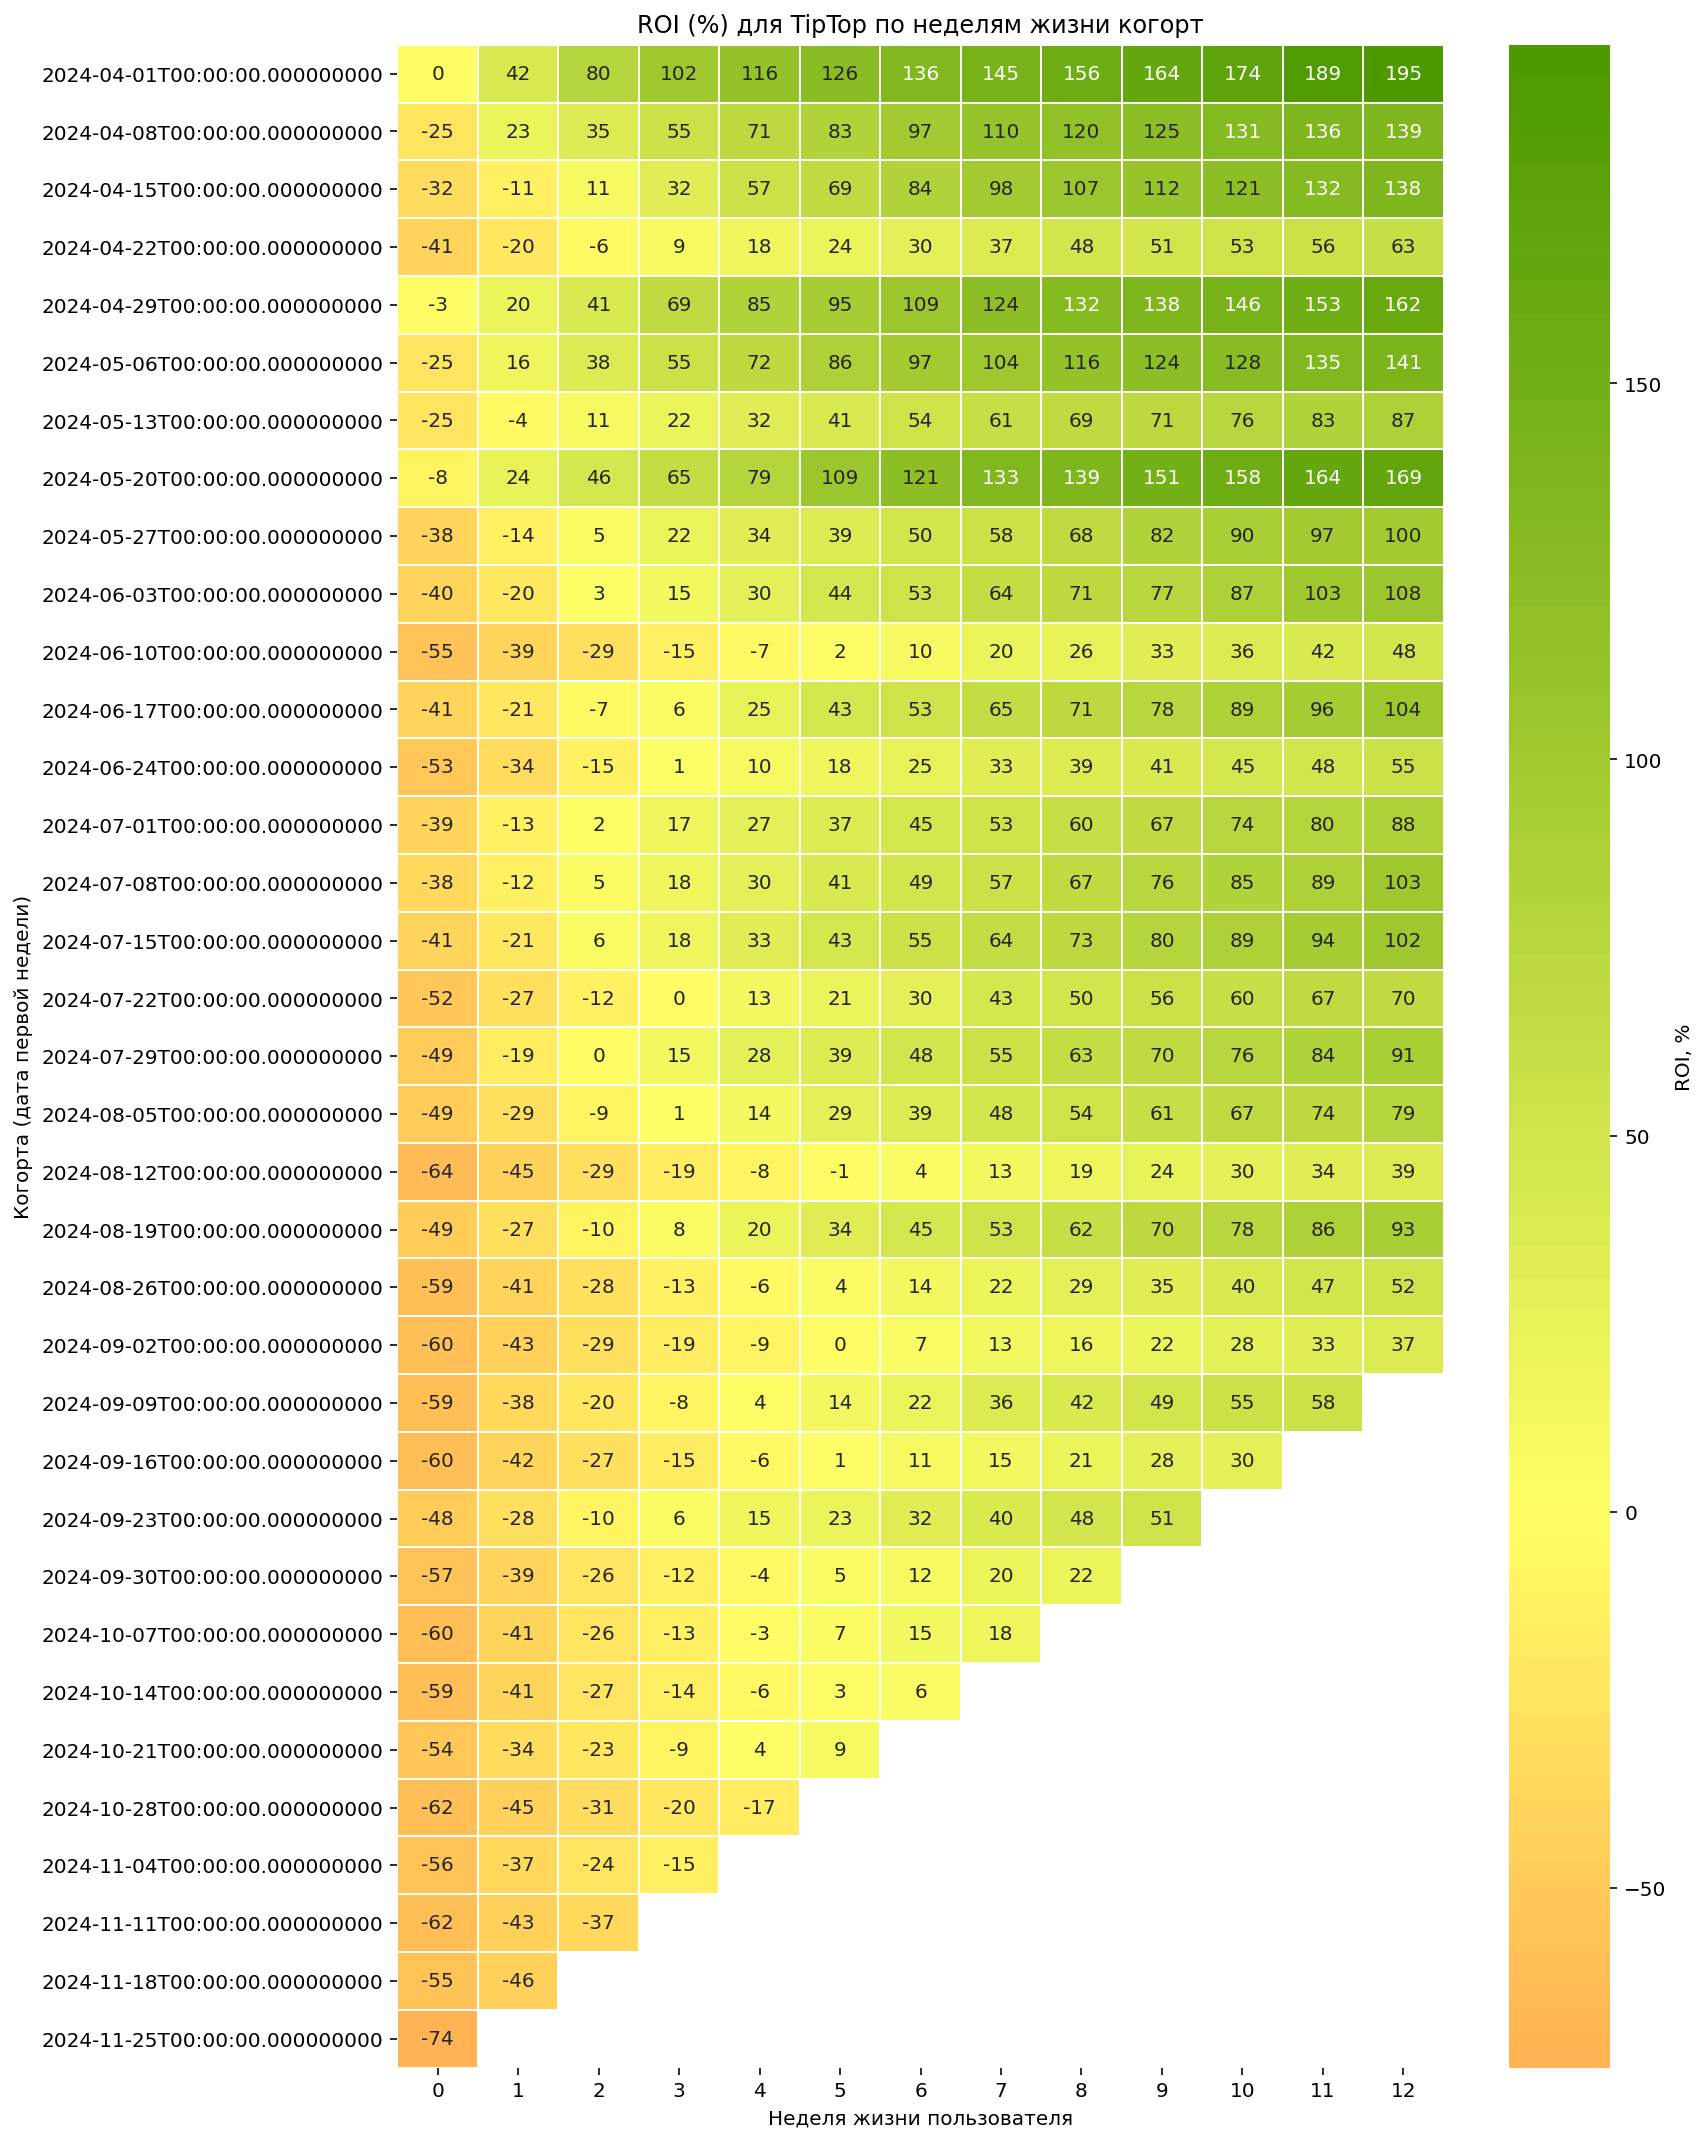

In [31]:
# Детальный ROI для TipTop
visits['cohort_week'] = visits['first_dt'] - pd.to_timedelta(visits['first_dt'].dt.weekday, unit='d')
visits['week_lifetime'] = (visits['lifetime'] // 7).astype(int)
visits_tiptop = visits[visits['first_channel']=='TipTop']
valid_pairs = visits_tiptop[['cohort_week','week_lifetime']].drop_duplicates()
visits_tiptop = visits[visits['first_channel']=='TipTop']
valid_pairs = (
    visits_tiptop[['cohort_week','week_lifetime']]
    .drop_duplicates()
)
roi_cohort = (
    full
    .groupby(['first_channel','cohort_week','week_lifetime'], as_index=False)
    .agg(mean_LTV=('cum_revenue','mean'))
    .merge(
        full[full['week_lifetime']==0]
        .groupby(['first_channel','cohort_week'], as_index=False)
        .agg(mean_cac=('cac','mean')),
        on=['first_channel','cohort_week']
    )
)
roi_cohort['ROI'] = (roi_cohort['mean_LTV'] - roi_cohort['mean_cac']) / roi_cohort['mean_cac']
tiptop = (
    roi_cohort.query("first_channel=='TipTop' and week_lifetime<=@MAX_WEEK")
    .merge(valid_pairs, on=['cohort_week','week_lifetime'], how='inner')
)
# Pivot
roi_tiptop = tiptop.pivot(
    index='cohort_week',
    columns='week_lifetime',
    values='ROI'
) * 100
# Маска и аннотации
annot = (
    roi_tiptop.round(0)
    .astype('Int64')
    .astype(str)
    .replace('<NA>','')
    .values
)
mask = roi_tiptop.isna()
cmap = mcolors.LinearSegmentedColormap.from_list(
    'r_y_g',['#FF3333','#FFFF66','#4C9900'], N=100
)


# Визуализация
plt.figure(figsize=(12, 1+0.4*len(roi_tiptop)))
sns.heatmap(
    roi_tiptop,
    mask=mask,
    annot=annot,
    fmt='',
    cmap=cmap,
    center=0,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label':'ROI, %'}
)
plt.title('ROI (%) для TipTop по неделям жизни когорт')
plt.xlabel('Неделя жизни пользователя')
plt.ylabel('Когорта (дата первой недели)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


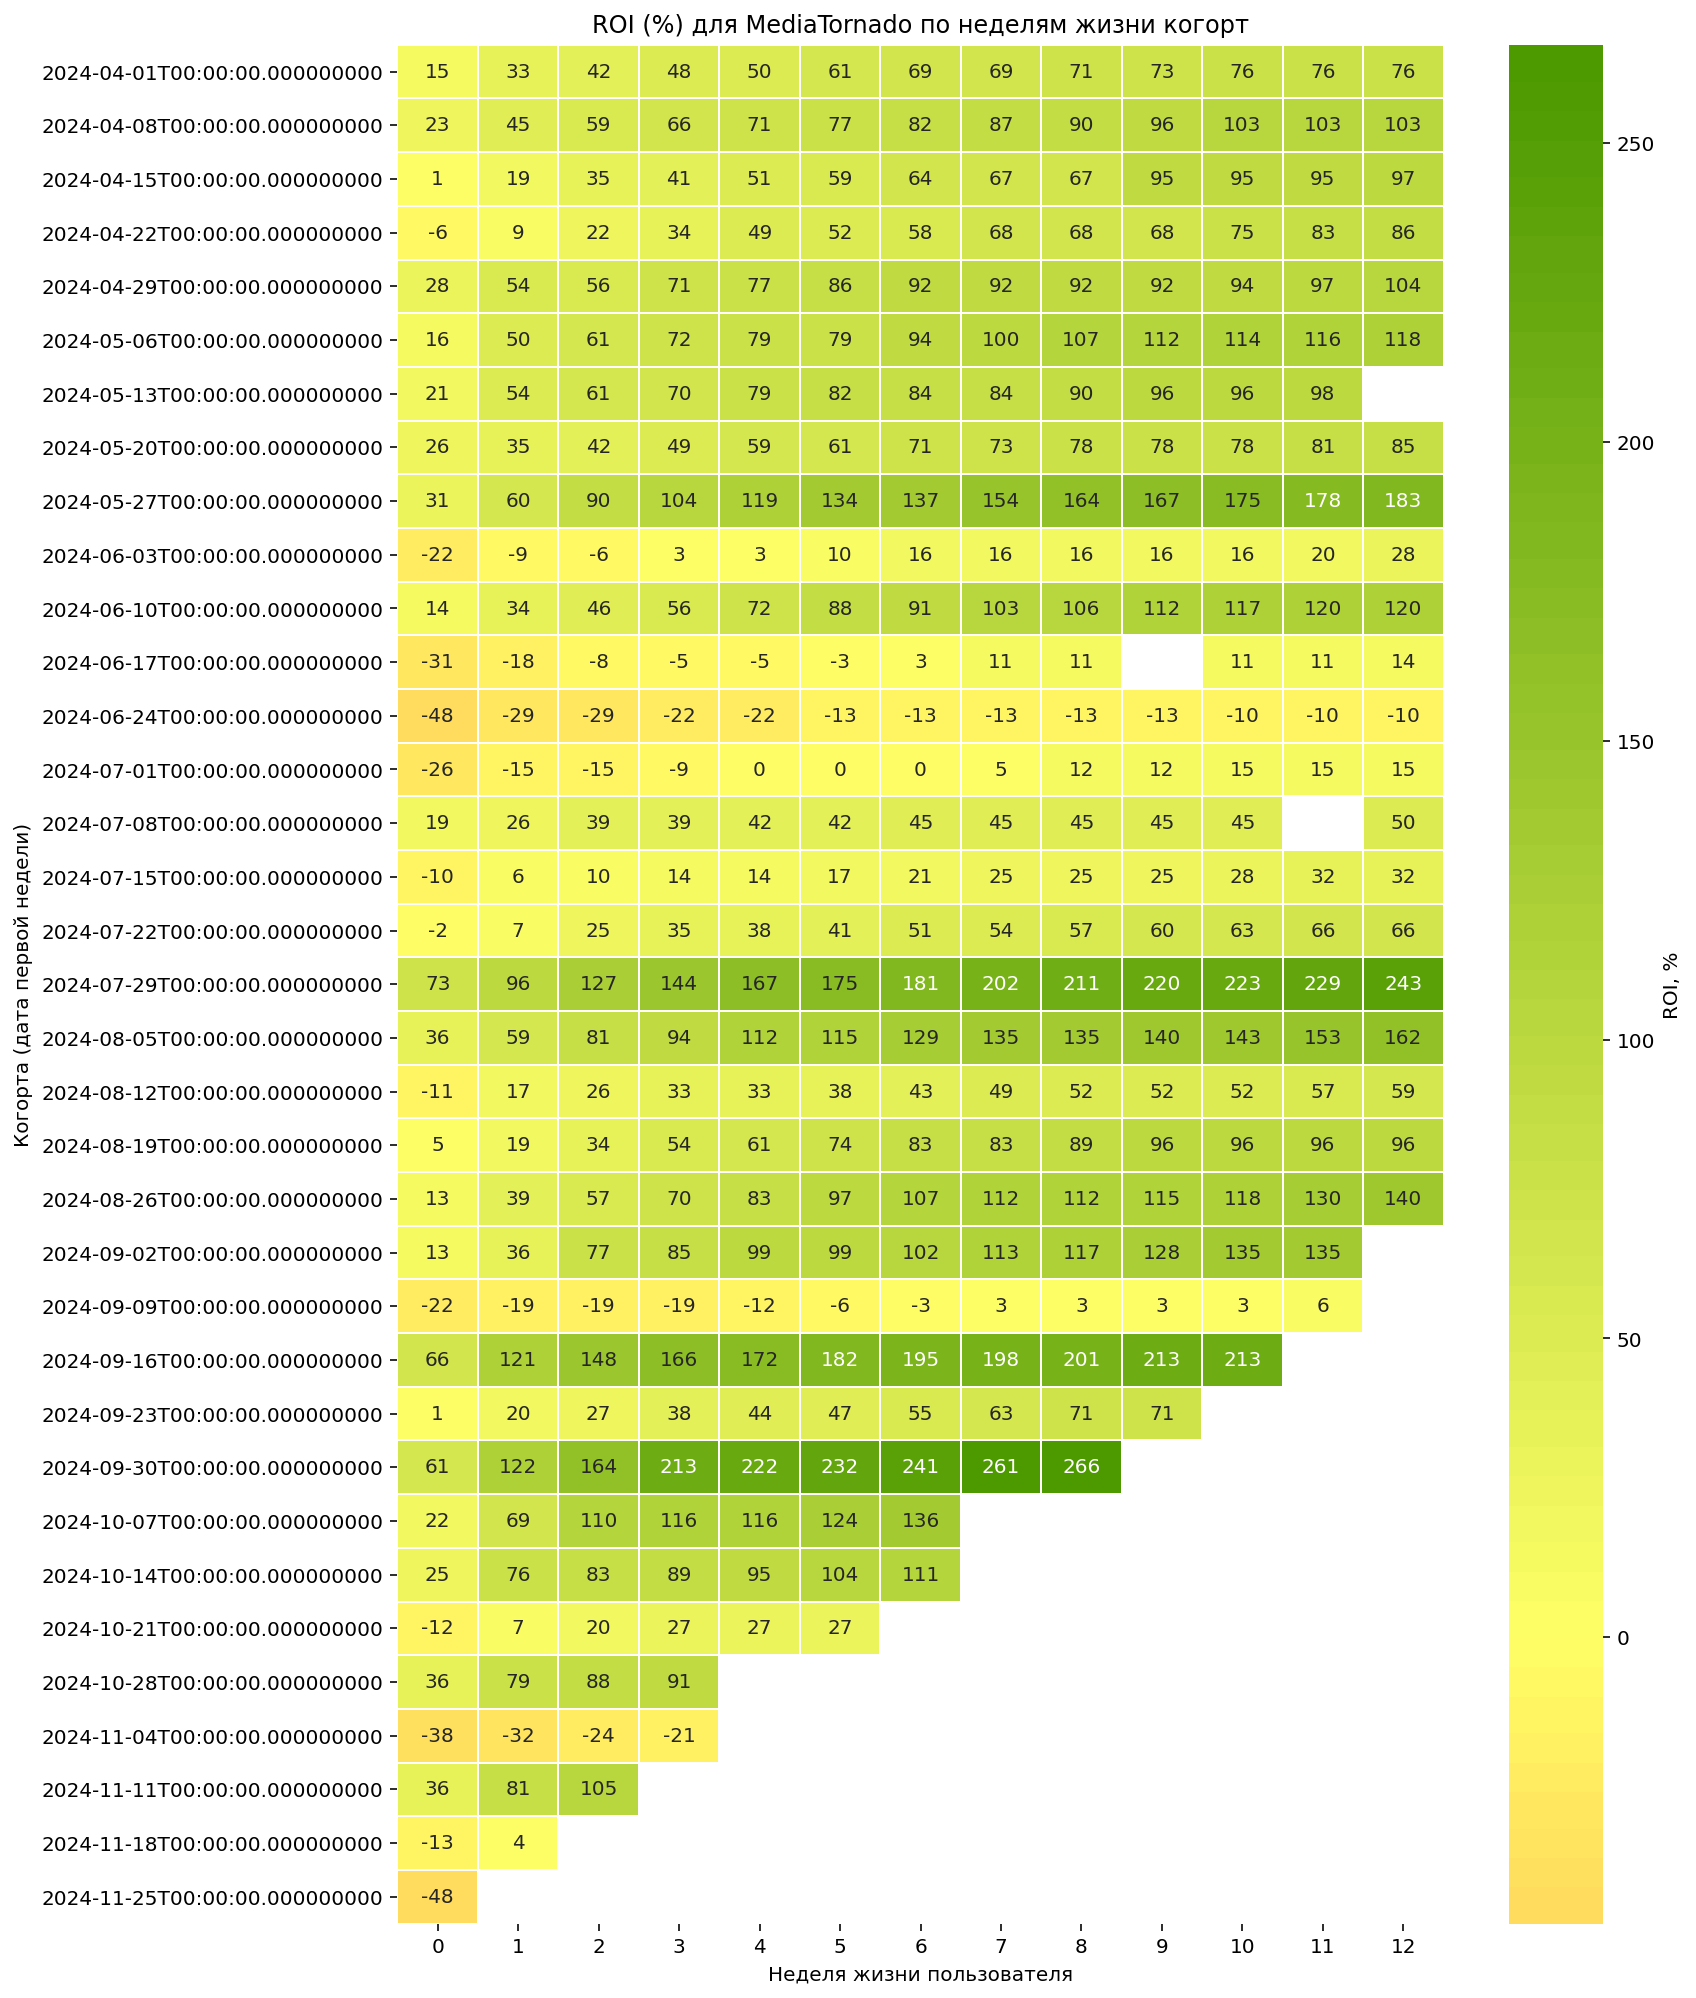

In [32]:
MAX_WEEK = 12

# Выбираем реальные пары (cohort_week, week_lifetime) для MediaTornado
visits_mt = visits[visits['first_channel']=='MediaTornado']
valid_pairs = visits_mt[['cohort_week','week_lifetime']].drop_duplicates()
# Группируем full
roi_cohort = (
    full
    .groupby(['first_channel','cohort_week','week_lifetime'], as_index=False)
    .agg(mean_LTV=('cum_revenue','mean'))
    .merge(
        # CAC средний в момент week_lifetime == 0
        full[full['week_lifetime']==0]
        .groupby(['first_channel','cohort_week'], as_index=False)
        .agg(mean_cac=('cac','mean')),
        on=['first_channel','cohort_week']
    )
)
# ROI
roi_cohort['ROI'] = (roi_cohort['mean_LTV'] - roi_cohort['mean_cac']) / roi_cohort['mean_cac']
# Оставляем только MediaTornado
mt = (
    roi_cohort
    .query("first_channel=='MediaTornado' and week_lifetime <= @MAX_WEEK")
    .merge(valid_pairs, on=['cohort_week','week_lifetime'], how='inner')
)
# Pivot 
mt_roi = (
    mt
    .pivot(index='cohort_week', columns='week_lifetime', values='ROI')
    * 100
)
# Готовим маску и аннотации
mask = mt_roi.isna()
annot = (
    mt_roi
    .round(0)
    .astype('Int64')
    .astype(str)
    .replace('<NA>','')
    .values
)
# Палитра (красный→жёлтый→зелёный) + белый для NaN
cmap = mcolors.LinearSegmentedColormap.from_list(
    'r_y_g',['#FF3333','#FFFF66','#4C9900'], N=100
)
cmap.set_bad('white')
# Рисуем тепловую карту
plt.figure(figsize=(12, max(4, len(mt_roi)*0.4)))
sns.heatmap(
    mt_roi,
    mask=mask,
    annot=annot,
    fmt='',
    cmap=cmap,
    center=0,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label':'ROI, %'}
)
plt.title('ROI (%) для MediaTornado по неделям жизни когорт')
plt.xlabel('Неделя жизни пользователя')
plt.ylabel('Когорта (дата первой недели)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


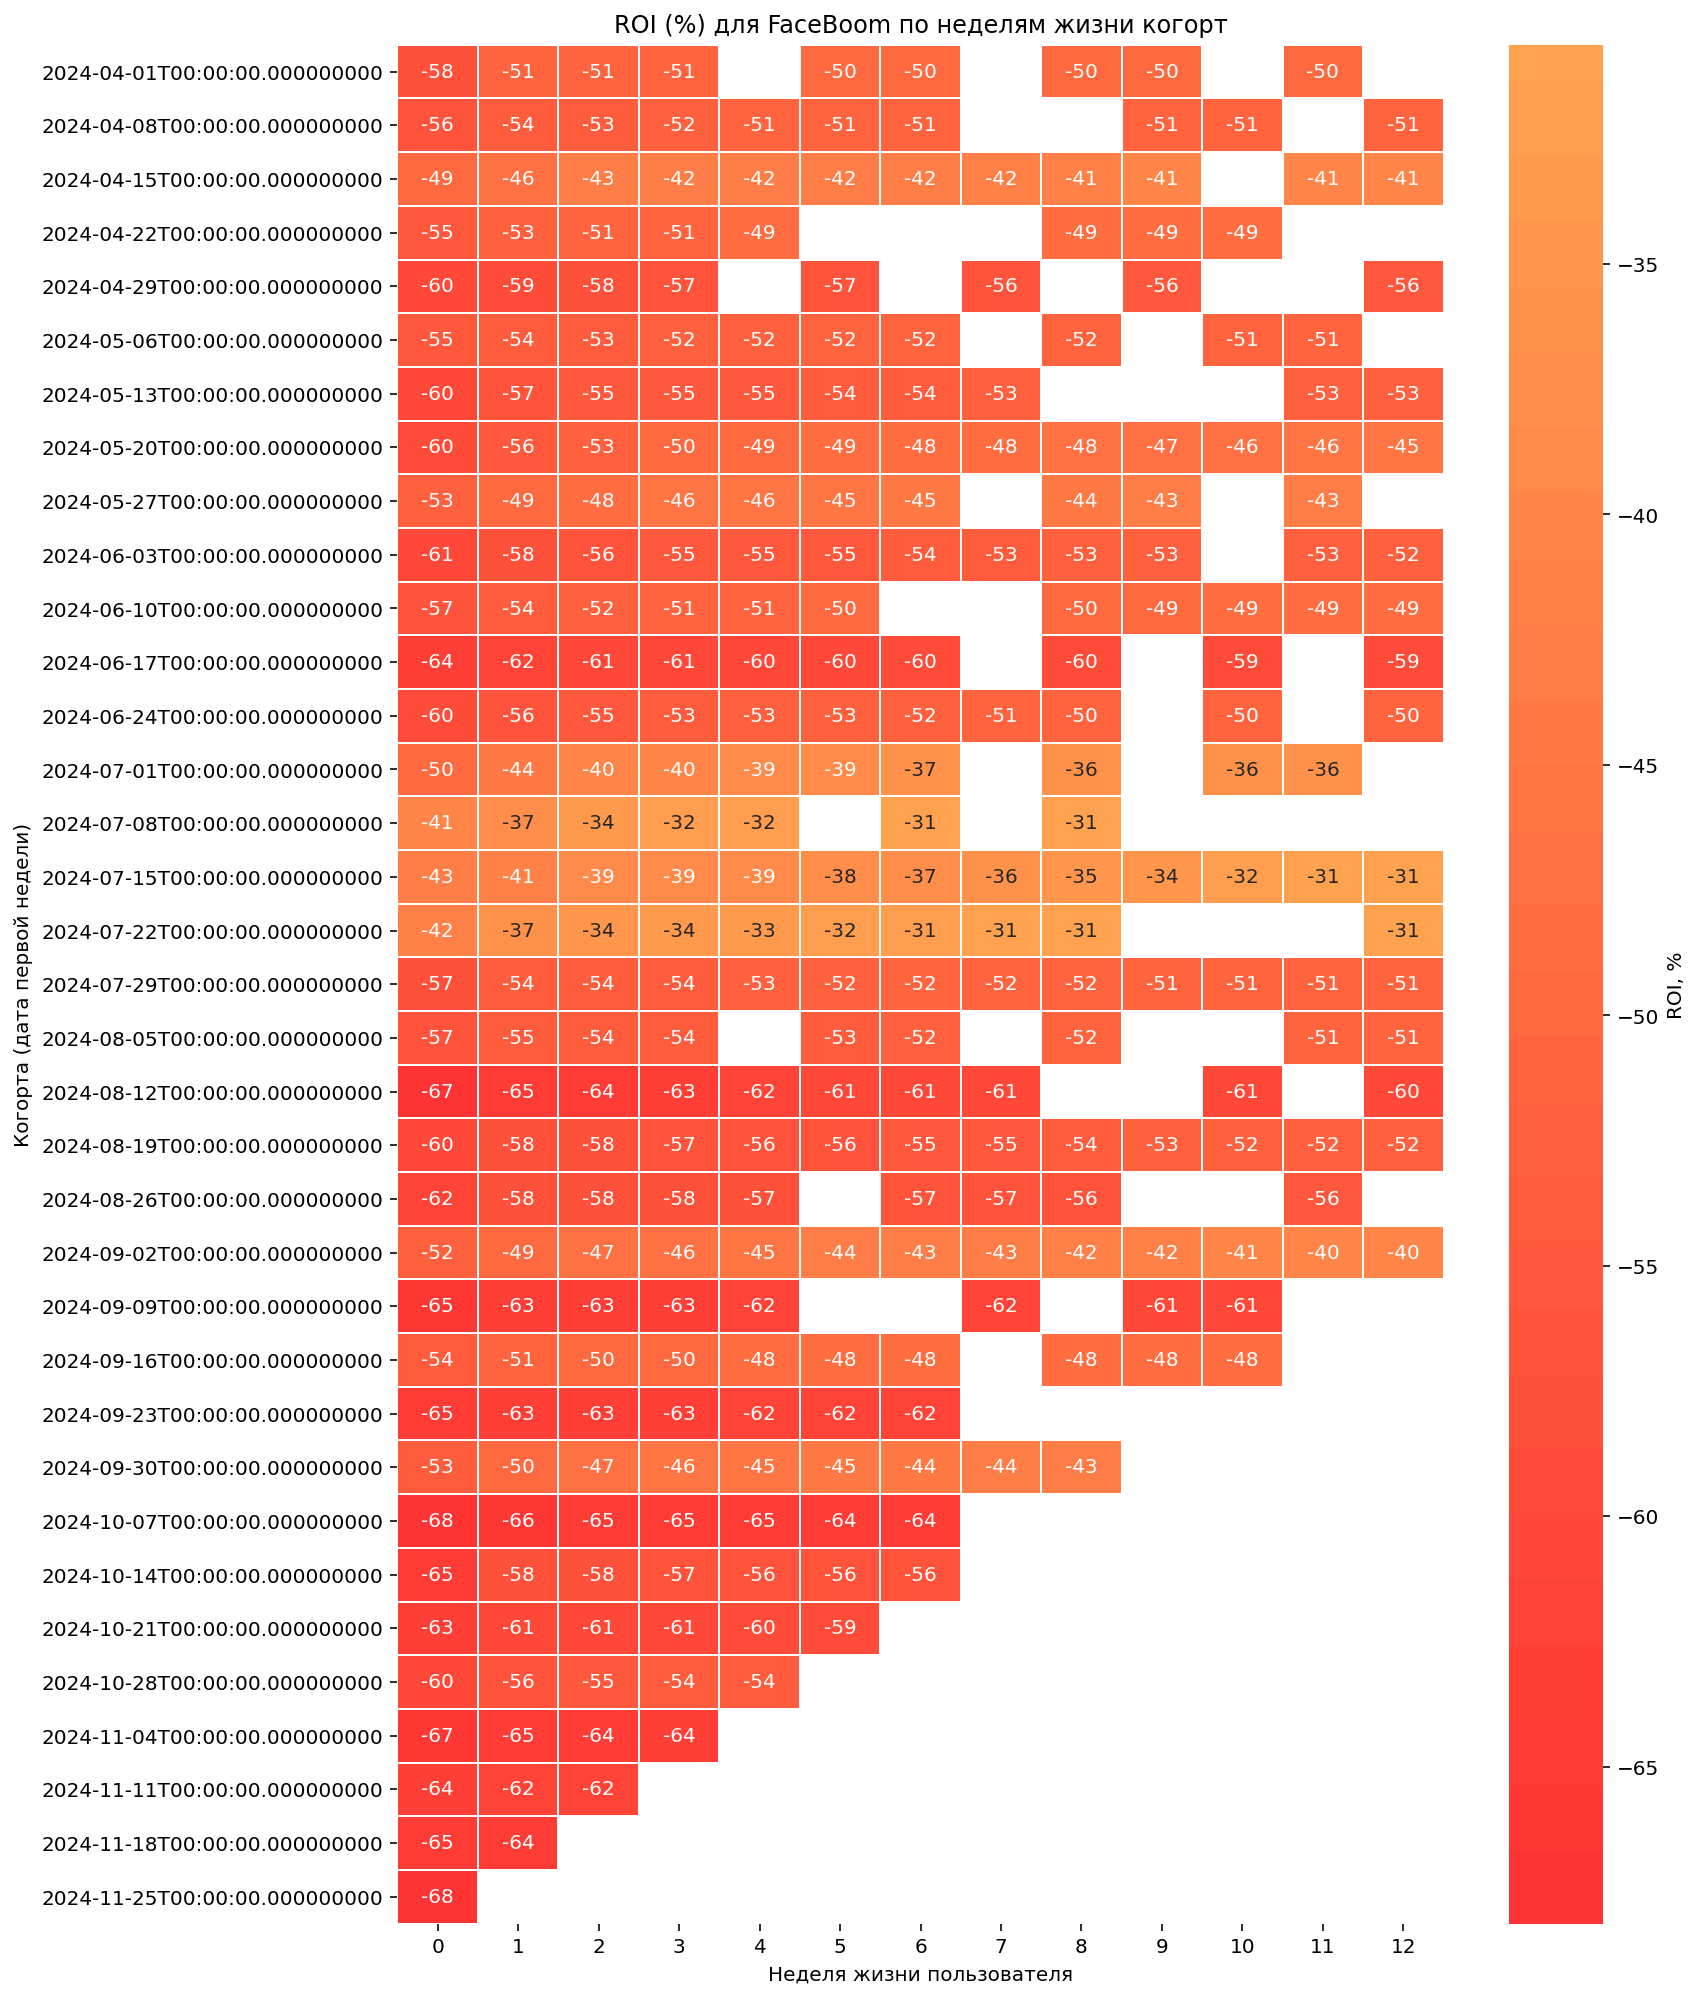

In [37]:
MAX_WEEK = 12

# Отбираем реальные пары (cohort_week, week_lifetime) для FaceBoom
visits_fb = visits[visits['first_channel']=='FaceBoom']
valid_pairs = visits_fb[['cohort_week','week_lifetime']].drop_duplicates()
# Группируем full, чтобы получить mean LTV и mean CAC по когорте
roi_cohort = (
    full
    .groupby(['first_channel','cohort_week','week_lifetime'], as_index=False)
    .agg(mean_LTV=('cum_revenue','mean'))
    .merge(
        full[full['week_lifetime']==0]
        .groupby(['first_channel','cohort_week'], as_index=False)
        .agg(mean_cac=('cac','mean')),
        on=['first_channel','cohort_week']
    )
)
roi_cohort['ROI'] = (roi_cohort['mean_LTV'] - roi_cohort['mean_cac']) / roi_cohort['mean_cac']
# Оставляем только FaceBoom, нужный диапазон недель и реальные пары
fb = (
    roi_cohort
    .query("first_channel=='FaceBoom' and week_lifetime <= @MAX_WEEK")
    .merge(valid_pairs, on=['cohort_week','week_lifetime'], how='inner')
)
# Pivot и переводим ROI в проценты
fb_roi = fb.pivot(
    index='cohort_week',
    columns='week_lifetime',
    values='ROI'
) * 100

# Маска для NaN и подготовка аннотаций
mask = fb_roi.isna()
annot = (
    fb_roi
    .round(0)
    .astype('Int64')
    .astype(str)
    .replace('<NA>','')
    .values
)
# Палитра: красный→жёлтый→зелёный, белый для NaN
cmap = mcolors.LinearSegmentedColormap.from_list(
    'r_y_g', ['#FF3333','#FFFF66','#4C9900'], N=100
)
cmap.set_bad('white')


# Рисуем тепловую карту
plt.figure(figsize=(12, max(4, len(fb_roi)*0.4)))
sns.heatmap(
    fb_roi,
    mask=mask,
    annot=annot,
    fmt='',
    cmap=cmap,
    center=0,
    linewidths=0.5,
    linecolor='white',
    cbar_kws={'label':'ROI, %'}
)
plt.title('ROI (%) для FaceBoom по неделям жизни когорт')
plt.xlabel('Неделя жизни пользователя')
plt.ylabel('Когорта (дата первой недели)')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


---
**Вывод по анализу окупаемости каналов привлечения**

Лучше всего окупается канал **RocketSuperAds** - он уже на третью неделю показывает более 100% ROI. 

Затем по окупаемости следует канал **MediaTornado** - он тоже показывает окупаемость сразу же, но не так успешно, как RocketSuperAds. По понедельной тепловой карте видно, что канал сильно тянут вниз старые когорты до конца мая и когорты в июне-июле. Когорты пользователей после конца июля окупаются гораздо быстрее.

Следующий канал - **TipTop**. Он окупается только после четвертой недели. По недельной тепловой карте видно, что более новые когорты окупаются все хуже. И если в июне канал окупался к четвертой неделе, то уже октябрьские когорты к пятой неделе все еще показывают -17%. 

Самый худший канал по окупаемости - **FaceBoom**. Его ROI не поднимается до положительных значений даже на 12 неделе. Если смотреть на недельную тепловую карту, то его показатели было плохими с самого начала наблюдения, стали немного лучше в июле, а к октябрю снова упали и в итоге в конце наблюдения стали хуже, чем были в начале.

---

## Выводы и рекомендации

Сформулируйте общий вывод. Зафиксируйте основные результаты и инсайты. Например, охарактеризуйте аудиторию продукта, покажите распределение маркетинговых затрат по каналам привлечения, опишите каждый канал привлечения. Делайте акцент на сильных и слабых сторонах. Укажите, какие каналы привлечения не вышли на окупаемость и по каким причинам.

Дайте рекомендации отделу маркетинга: опишите, как повысить эффективность вложений в рекламу.


Продукт активно использует четыре канала привлечения: FaceBoom, MediaTornado, RocketSuperAds и TipTop. Аудитория демонстрирует явные отличия по удержанию, стоимости привлечения (CAC), LTV и ROI в зависимости от канала. Некоторые каналы уверенно выходят на окупаемость в течение 28 дней, тогда как другие — нет.

**Основные результаты**

- Метрики вовлеченности растут на всем протяжении - DAU, MAU, Stickiness. 
- Финансовые метрики показывают падение окупаемости из-за роста стоимости привлечения пользователей после пика в июле.
- **Каналы**:
  - **FaceBoom**: самый большой по количеству привлеченных пользователей, но меньше всего удержание, за счет чего конверсия падает, хотя находится на хорошем уровне. Средний по стоимости, но LTV низкий. Не окупается на всем протяжении наблюдения - стабильно низкий ROI.
  - **TipTop**: пользователи дольше всего держатся, за счет чего растет DAU и MAU, что влияет на конверсию в покупку - она одна из самых высоких и растет. Но канал самый дорогой и его стоимость очень резко увеличилась в октябре. LTV тоже растет и остается самым высоким из всех каналов. Однако, этого уровня не хватает и канал все равно не окупается, ROI падает. Со временем канал рискует стать убыточным.
  - **RocketSuperAds** привлекает мало пользователей, но они хорошо удерживаются. Стоимость падает. При этом LTV очень высокий - соответственно ROI на высоком уровне (самый высокий из всех каналов).
  - **MediaTornado** привлек меньше всего пользователей, при этом конверсия в покупку самая низкая. Стоимость канала самая низкая. Поэтому даже при низком LTV ROI достаточный для окупаемости и продолжает расти, хотя имеет высокий шум. В целом нововведения хорошо повлияли на этот канал.

**Рекомендации:**
- Оптимизировать бюджет на каналы с низкой окупаемостью: сократить инвестиции в FaceBoom, TipTop при всех сильных сторонах нуждается в переоценке условий закупки трафика или замене подрядчика.
- Укрепить фокус на эффективных и устойчивых каналах: рекомендуется расширение использования канала RocketSuperAds при сохранении текущей модели закупки; MediaTornado - возможен эксперимент с увеличением бюджета в тестовом режиме.
- Контроль стоимости привлечения (CAC). Основной фактор падения ROI — рост стоимости привлечения. Рекомендуется установить порог CAC на уровне, позволяющем выйти на окупаемость за 28 дней, и мониторить его по каждому каналу.
- Учитывать сезонность и пересматривать ставки закупки: всплеск затрат на TipTop в октябре указывает на возможность сезонных колебаний. Рекомендуется учитывать сезонность при формировании рекламного бюджета и оценке эффективности каналов.
- Углубить анализ поведения пользователей в первые 7 и 14 дней, чтобы точнее определить точки оттока.